In [174]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Topic: EX1 - Growth

**Task**: Predict the **average annual percentage growth** of real Gross Domestic Product (growth, ger. "Bruttoinlandsprodukt").

**Data**: On average growth rates over 1960-1995 for 65 countries, along with variables that are potentially related to growth.
These data were provided by Professor Ross Levine of Brown University and were used in his paper with, Thorsten Beck and Norman Loayza “Finance and the Sources of Growth” Journal of Financial Economics, 2000, Vol. 58, pp. 261- 300.

# Imports

In [176]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, LinearRegression, Lasso
from sklearn.svm import SVR

from catboost import CatBoostRegressor

from xgboost.sklearn import XGBRegressor

In [177]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

In [178]:
np.random.seed(42)

# Configs

In [179]:
FEATURES_TO_DROP = ["oil"]
#SELECTED_FEATURES =
TARGET = "growth"
#TRAIN_SIZE = 0.8
K = 10
STANDARDIZE = True
OHE = True
AUGMENTED_DATA = 150
REGION_FEATURES = ["region_name"] #geopolitical_region_name
BEST_PARAMS = {'depth': 10, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
BASELINE_MODEL = CatBoostRegressor(random_state=42, **BEST_PARAMS)

# Load the data

In [180]:
# make sure using european decimal seperator (',')! default is american ('.')
holdout = pd.read_csv("../../data/raw/teco-psda-exercisesheet1-growth-2024/growth_test.csv", index_col=0, sep=',', decimal=',')
train = pd.read_csv("../../data/raw/teco-psda-exercisesheet1-growth-2024/growth_train.csv", index_col=0, sep=',', decimal=',')

In [181]:
# check shape
print("Shape of holdout: ", holdout.shape)
print("Shape of train: ", train.shape)

Shape of holdout:  (20, 7)
Shape of train:  (45, 8)


In [182]:
# check data types
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 1 to 63
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   45 non-null     object 
 1   growth         45 non-null     float64
 2   oil            45 non-null     int64  
 3   rgdp60         45 non-null     float64
 4   tradeshare     45 non-null     float64
 5   yearsschool    45 non-null     float64
 6   rev_coups      45 non-null     float64
 7   assasinations  45 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.2+ KB


In [183]:
# data preview
train.head(10)

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333
8,Peru,0.060206,0,2019.000244,0.324613,3.02,0.266667,0.566667
11,Italy,2.932981,0,4564.000488,0.330022,4.56,0.033333,1.200000
12,Greece,3.224050,0,2093.000000,0.337879,4.37,0.166667,0.166667
13,France,2.431281,0,5823.000488,0.339706,4.65,0.000000,0.300000
14,Zaire,-2.811944,0,488.999908,0.352318,0.54,0.148148,0.055556
15,Uruguay,1.025309,0,3967.999756,0.358857,5.07,0.000000,0.166667
17,Pakistan,2.698163,0,638.000000,0.417604,0.63,0.266667,0.266667
18,Niger,-2.751478,0,531.999878,0.425837,0.20,0.133333,0.000000


In [184]:
holdout.head(10)

,country_name,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,0,765.999817,0.140502,1.45,0.133333,0.866667
2,Japan,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,0,1783.999878,0.160405,2.89,0.100000,0.100000
5,Bangladesh,0,951.999817,0.221458,0.79,0.306481,0.175000
6,Spain,0,3123.001465,0.299406,3.80,0.066667,1.433333
7,Colombia,0,1684.000366,0.313073,2.97,0.100000,0.766667
9,Haiti,0,923.999939,0.324746,0.70,0.374074,0.200000
10,Australia,0,7782.002441,0.329479,9.03,0.000000,0.066667
16,Mexico,0,2836.000244,0.393251,2.41,0.000000,0.166667
20,Germany,0,6569.998535,0.442143,7.64,0.066667,0.233333


Findings:
* Typecasting of categorical feature for performance improvement. Can be done since the feature "country_name" fits as suggested in pandas [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html).
* Ids are different, it seems like the holdout set and train set was split and possibly the data sets contain no overlapping countries. This should be checked.

In [185]:
train["country_name"] = train["country_name"].astype("category")
holdout["country_name"] = holdout["country_name"].astype("category")
# rename index column to ID
train.index.name = "Id"
holdout.index.name = "Id"
#train.head(5)

#### Check stats

In [186]:
# check stats - categorical
train.describe(include="category")

,country_name
count,45
unique,45
top,Argentina
freq,1


In [187]:
# check stats - numeric
train.describe()

,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
count,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000
mean,1.847426,0.0,2997.489067,0.582602,3.740222,0.191934,0.277531
std,2.016963,0.0,2523.564715,0.220926,2.353967,0.254682,0.545096
min,-2.811944,0.0,366.999939,0.156623,0.200000,0.000000,0.000000
25%,0.617645,0.0,1133.000000,0.455769,1.700000,0.000000,0.000000
50%,1.712265,0.0,1869.000000,0.552722,3.450000,0.066667,0.066667
75%,2.889185,0.0,4963.998535,0.681555,4.990000,0.266667,0.200000
max,7.156855,0.0,9895.003906,1.127937,9.550000,0.970370,2.466667


# Explanatory Data Analysis (EDA)

#### Check vor NaN, 0.0 values

In [188]:
# check vor NaN, 0.0 values
empty_value_count = train.isna().sum().rename("NaN").to_frame().join(train.eq(0.0).sum().rename("0.0"))
empty_value_count["total"] = empty_value_count.sum(axis=1)
empty_value_count["total %"] = (empty_value_count["total"] / train.shape[0] * 100).round(2)
empty_value_count

,NaN,0.0,total,total %
country_name,0,0,0,0.00
growth,0,0,0,0.00
oil,0,45,45,100.00
rgdp60,0,0,0,0.00
tradeshare,0,0,0,0.00
yearsschool,0,0,0,0.00
rev_coups,0,15,15,33.33
assasinations,0,16,16,35.56


Findings:
* No NaN values to handle.
* ```oil``` feature has only 0 values, thus includes no information --> add feature ```oil``` to drop list

#### Check for duplicates

In [189]:
# check duplicates
print("Duplicates:" , train.duplicated().any())

Duplicates: False


In [190]:
# check for duplicates in the country_name feature with the holdout set
overlap = train["country_name"].isin(holdout["country_name"])
overlap.sum()

0

Findings:
* If there is no overlap the feature ```country_name``` is unique and serves like an ID and does not help predicting the holdout set. Also using the feature for training would require an encoding since it is a categorical feature, then the problem is that the holdout set would have a different encoding since it contains different unique values. Therefore, the holdout set could not be predicted with the model trained on the training set with the other encoding.
* However, it can be used to generate a new feature carrying the location information of the country. This can be done by mapping the country to a region (e.g. Europe, Asia, Africa, Americas, Oceania). And also adding longitude and latitude information of the country center as numeric features if available.

#### Check feature distributions

1. **Histogram of Numeric Features**

In [191]:
# check feature distributions - numeric
df = train.drop('country_name', axis=1)

nrows = df.shape[1] // 3 + df.shape[1] % 3
ncols = 3

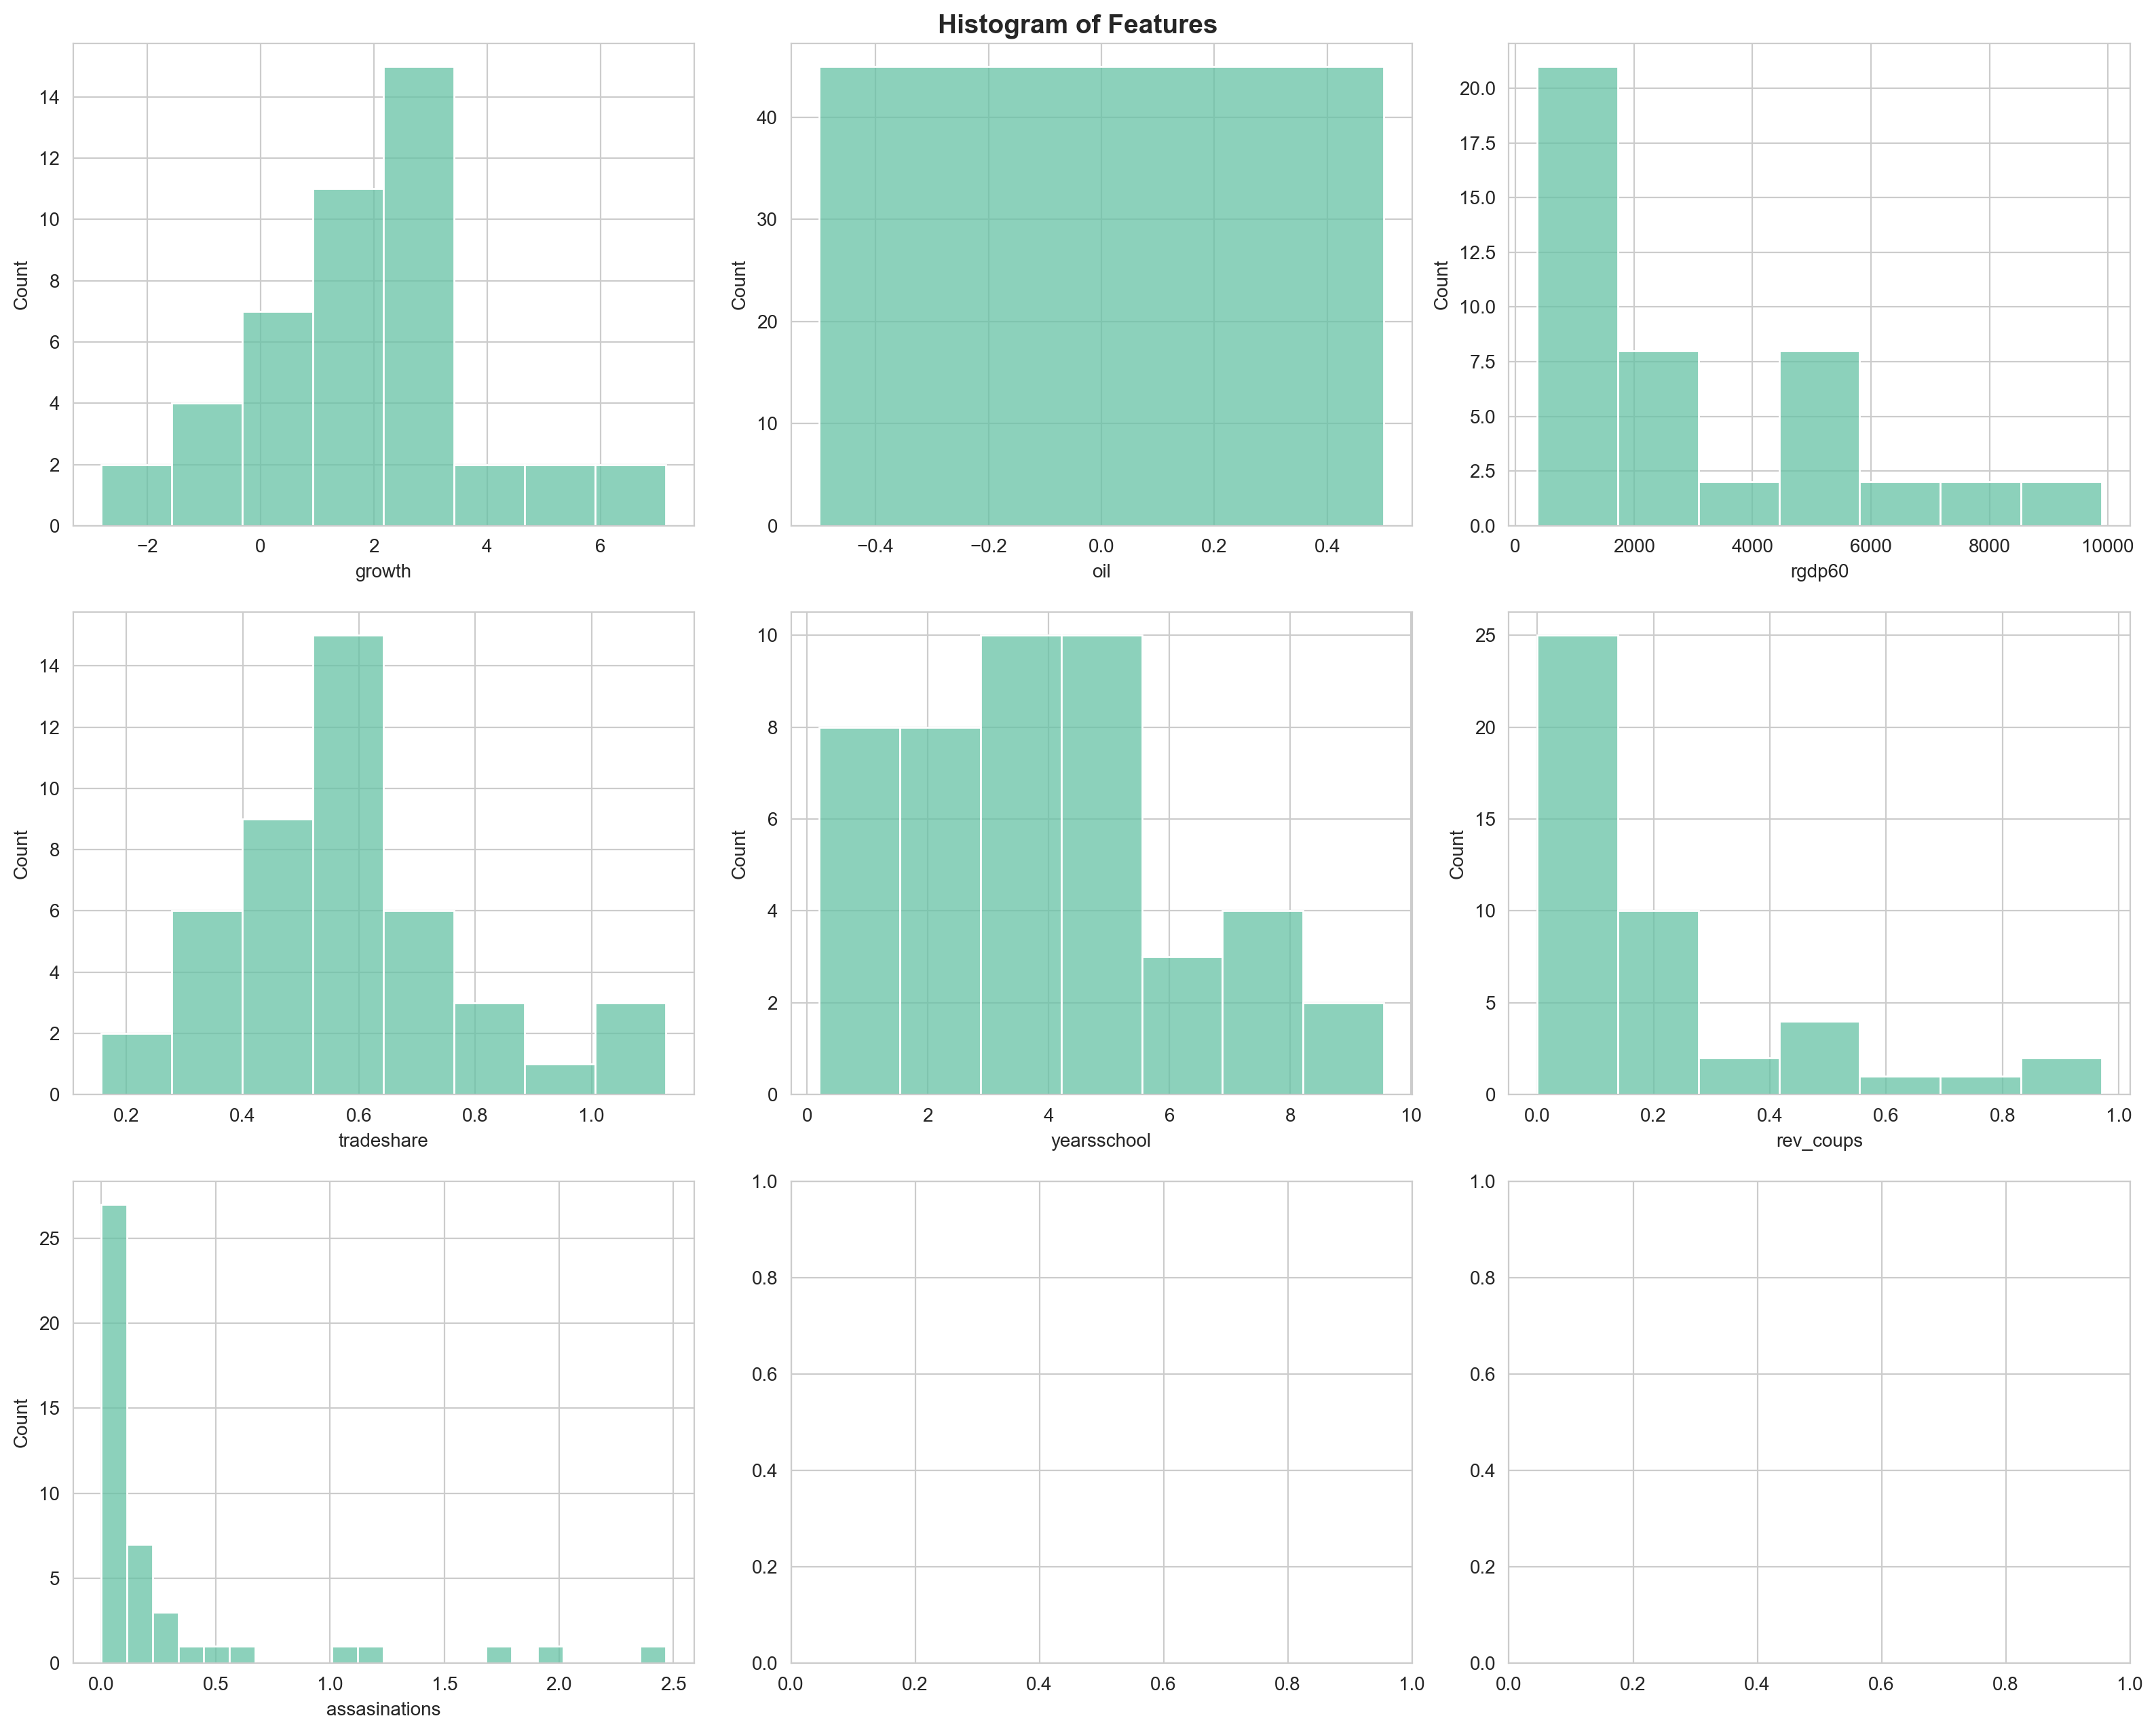

In [192]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 13))
fig.suptitle("Histogram of Features", fontsize=14, fontweight="bold")
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axes[i // ncols, i % ncols], common_norm=False)
plt.tight_layout()
plt.show()

2. **Feature Distribution Relative to GDP growth (target feature)**

In [193]:
# check feature distribution relative to the actual target (growth)
df = train.drop(['growth', 'country_name', 'oil'], axis=1)
target = train["growth"]

nrows = df.shape[1] // 3 + (df.shape[1]-1) % 3
ncols = 3

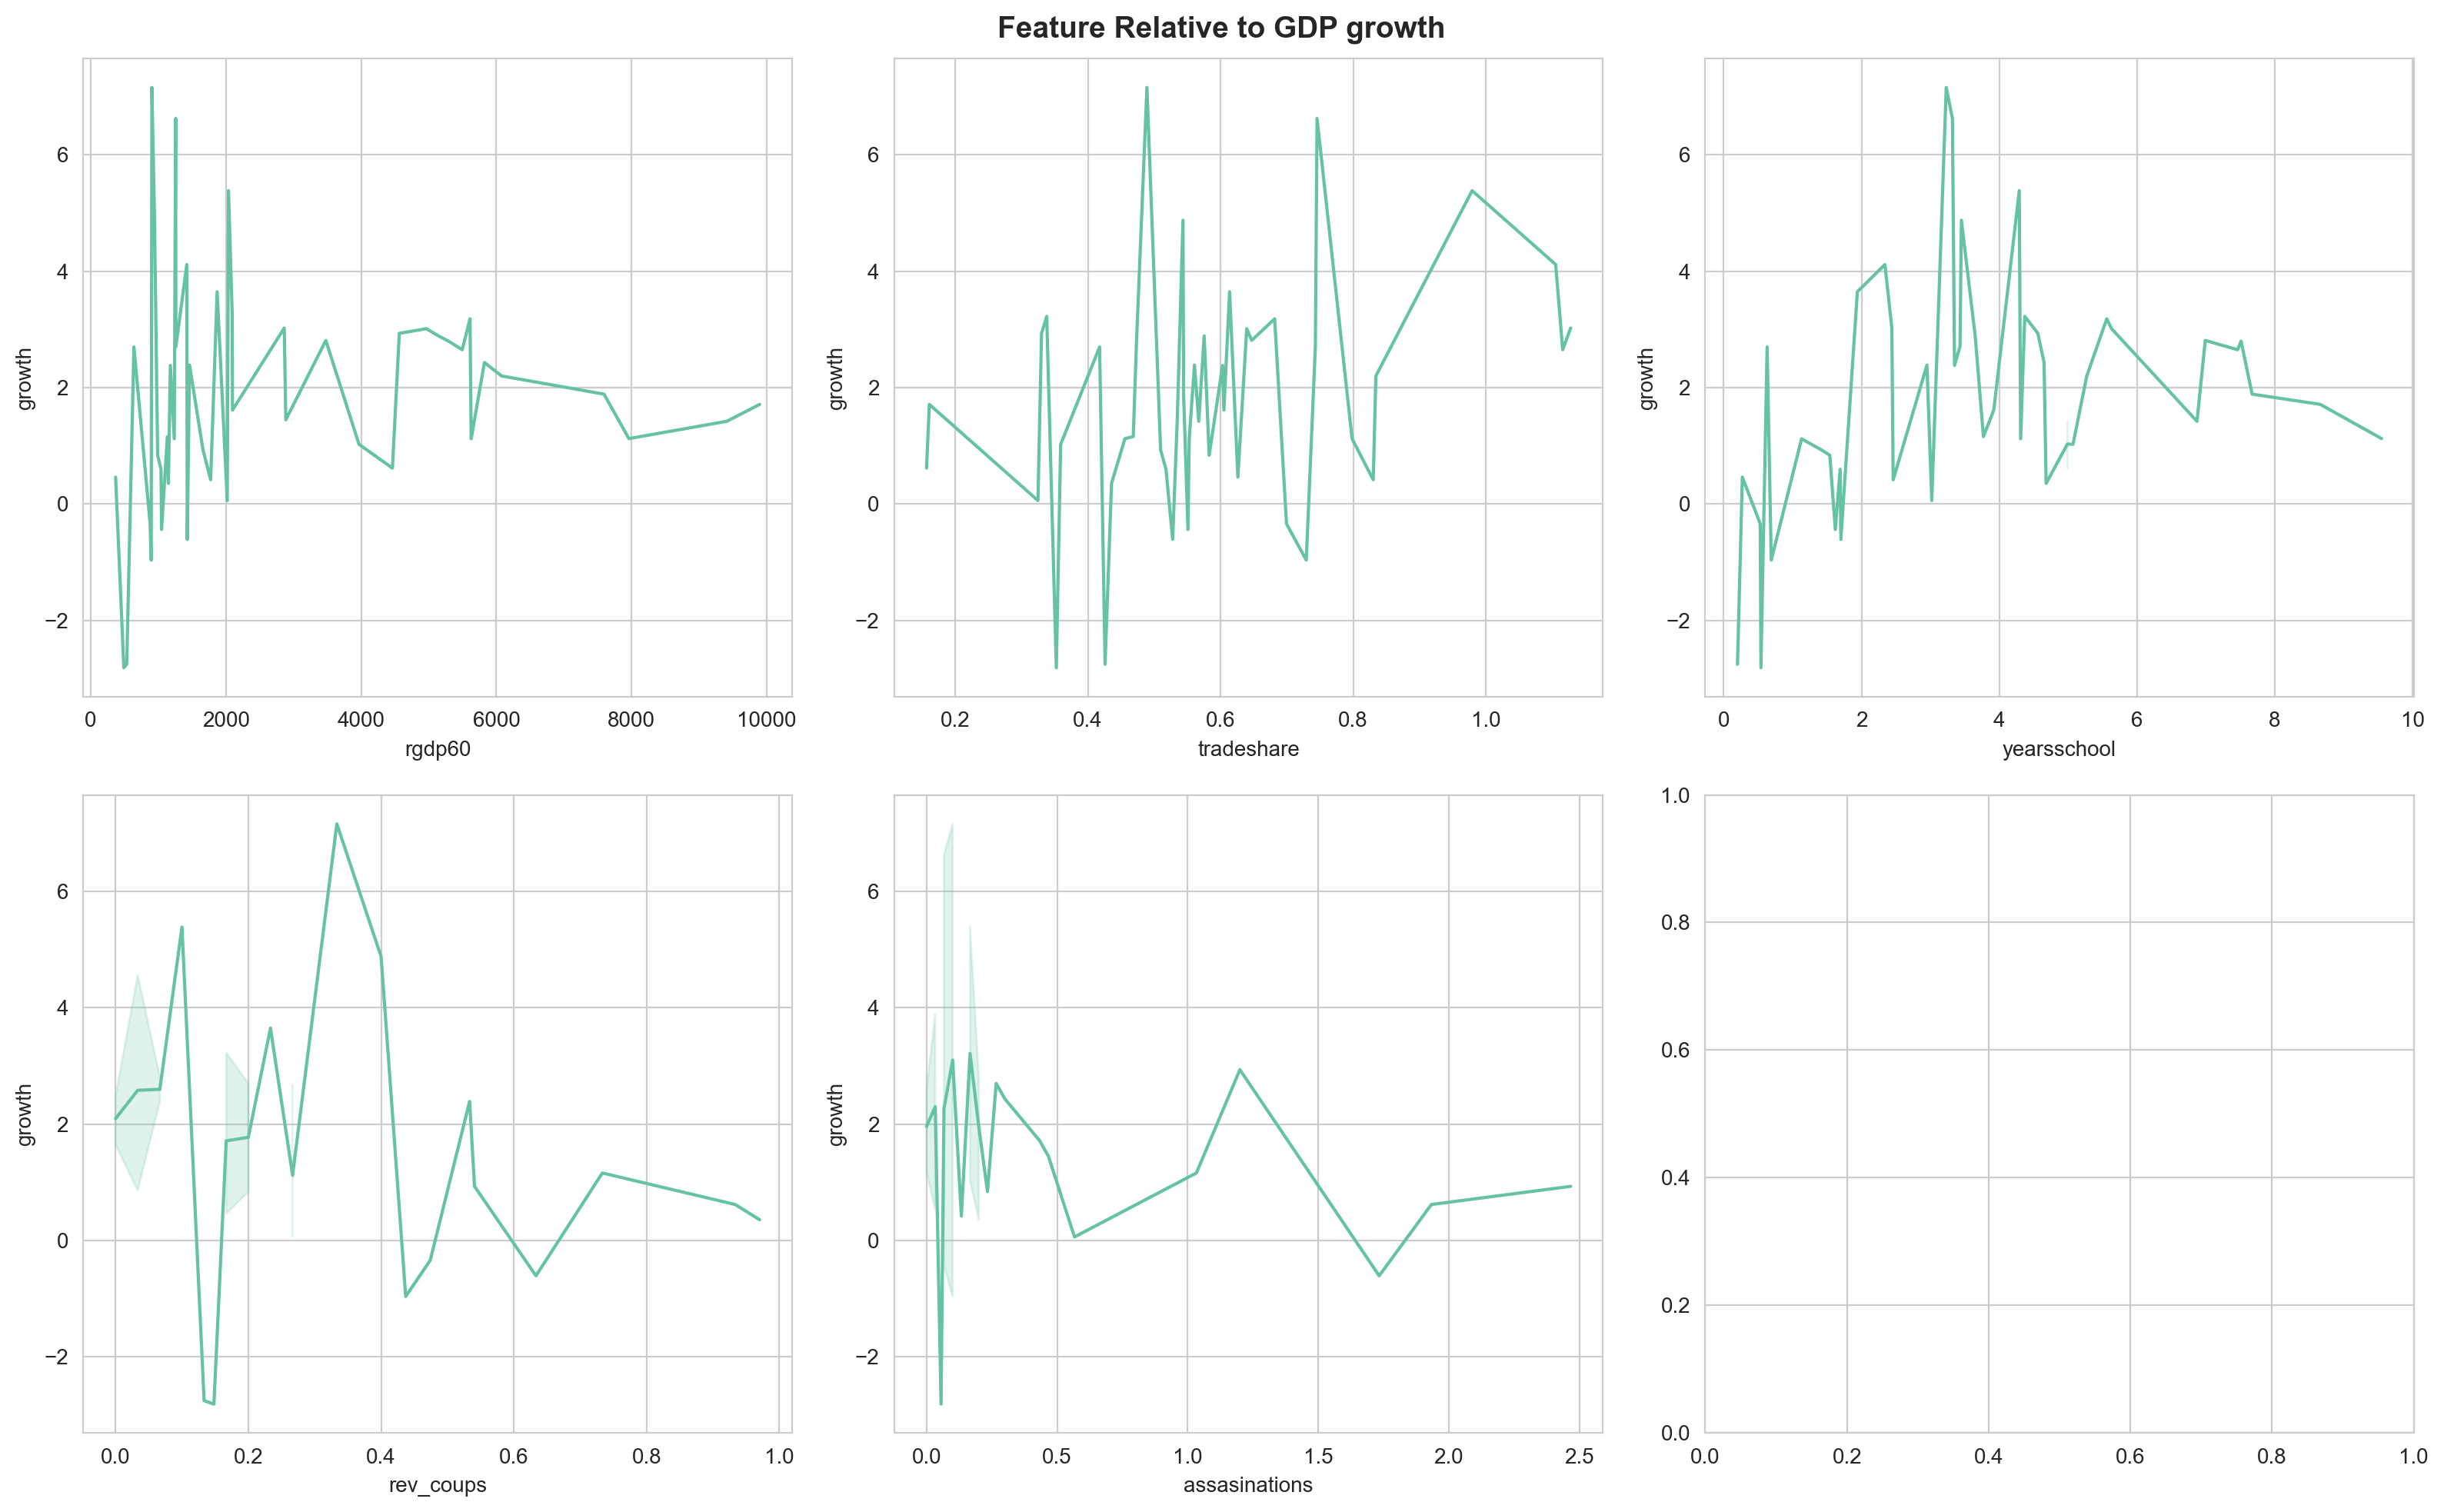

In [194]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))
fig.suptitle("Feature Relative to GDP growth", fontsize=14, fontweight="bold")
for i, col in enumerate(df.columns):
    # sns.scatterplot(data=df, x=col, y=target, ax=axes[i // ncols, i % ncols])
    sns.lineplot(data=df, x=col, y=target, ax=axes[i // ncols, i % ncols])
plt.tight_layout()
plt.show()

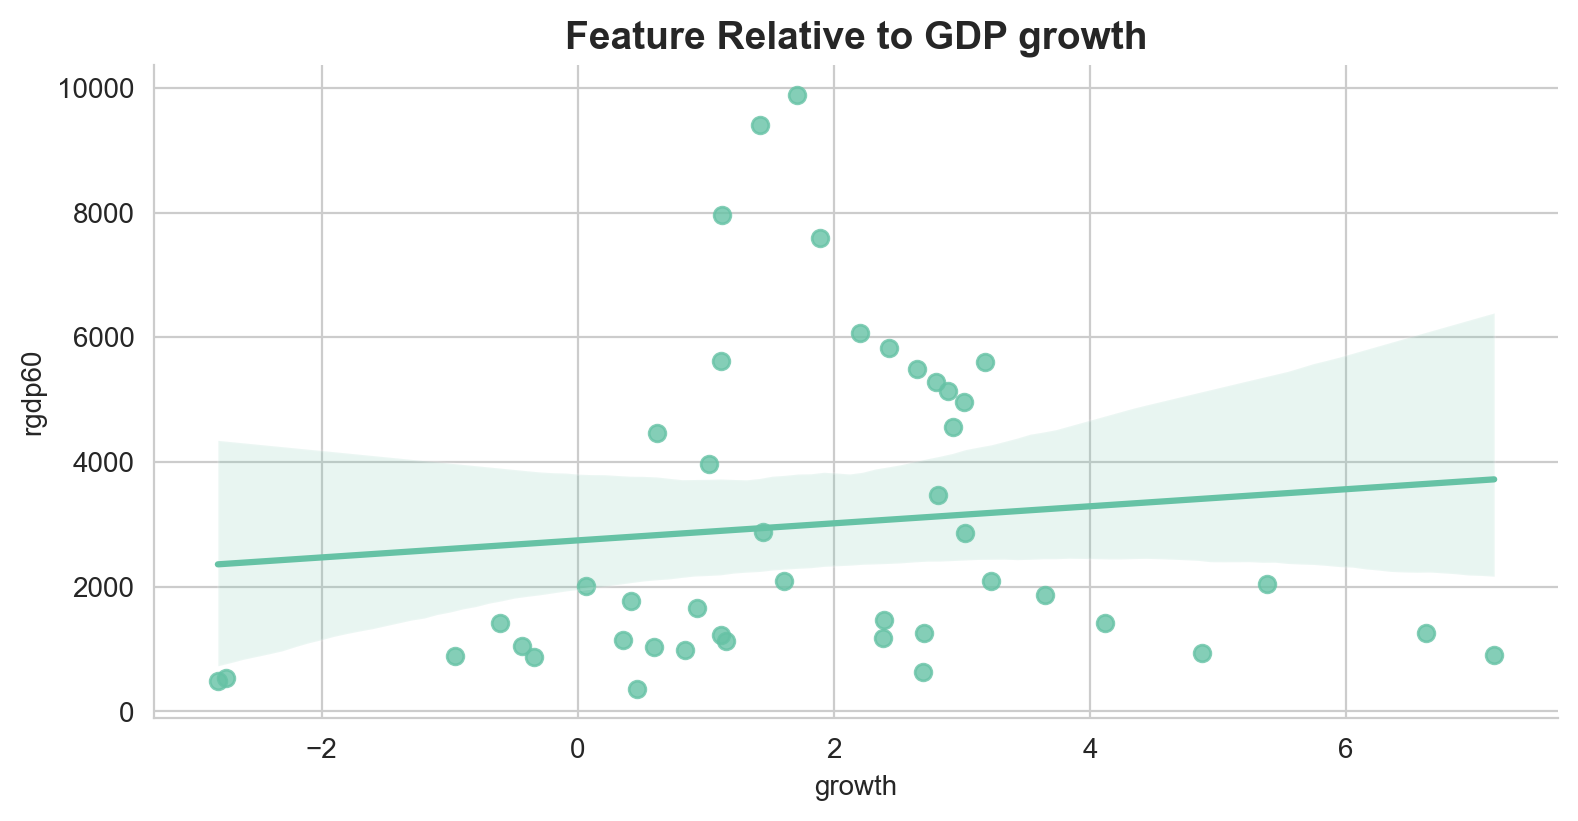

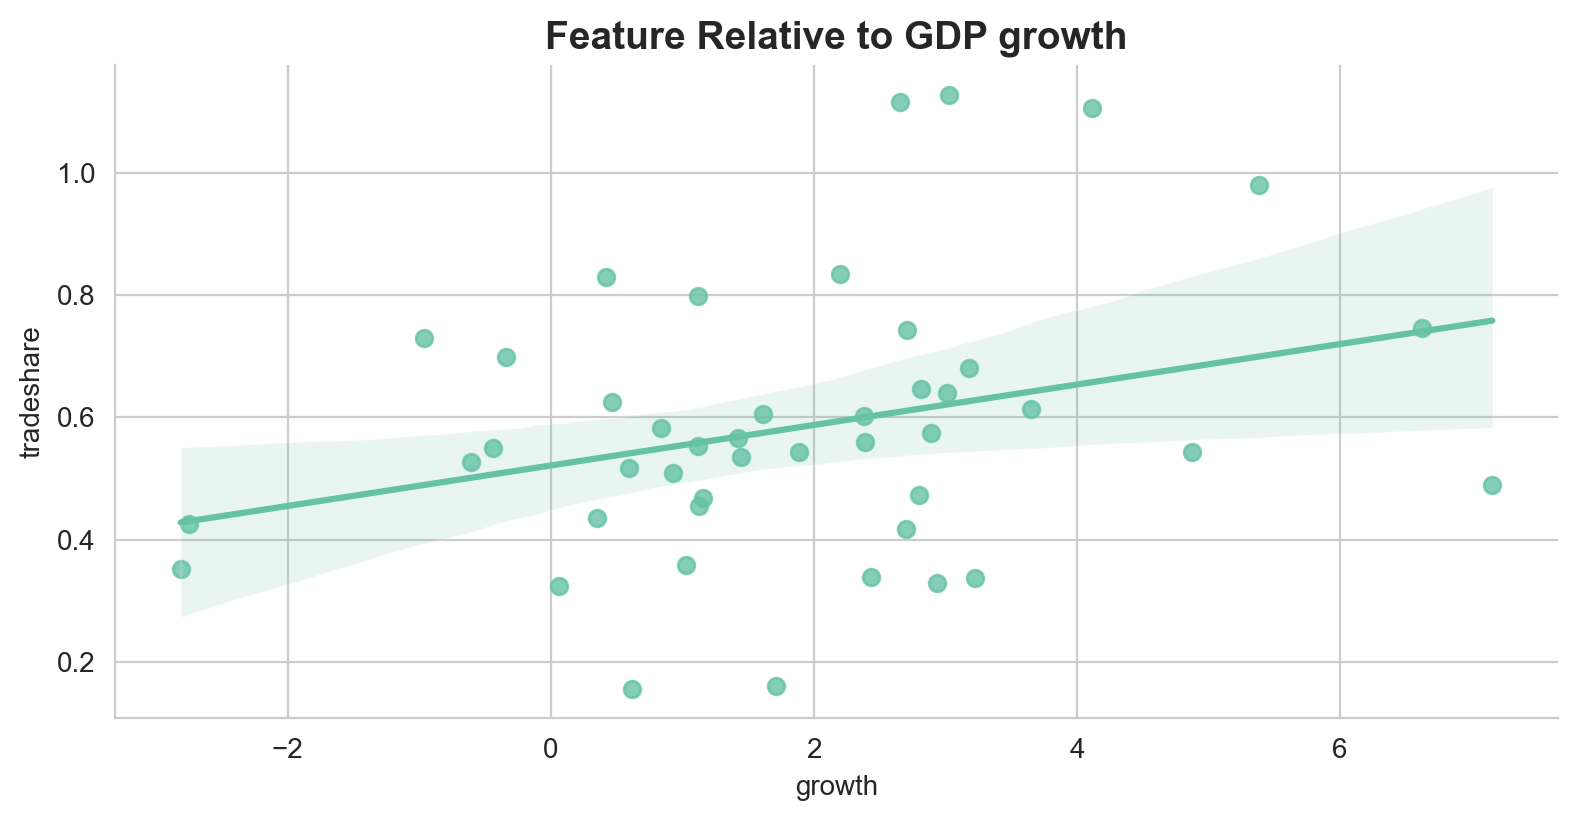

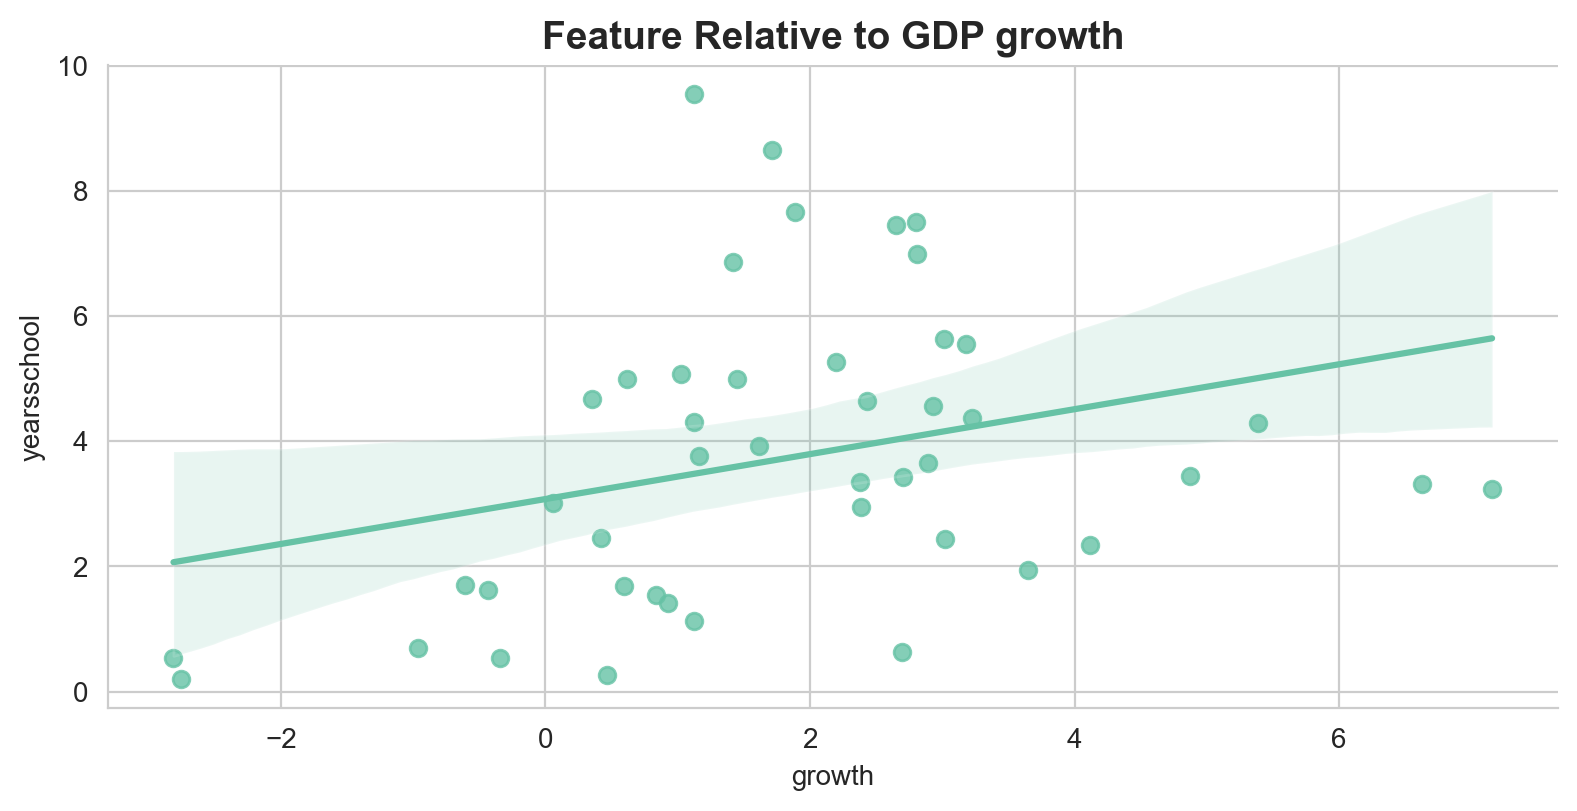

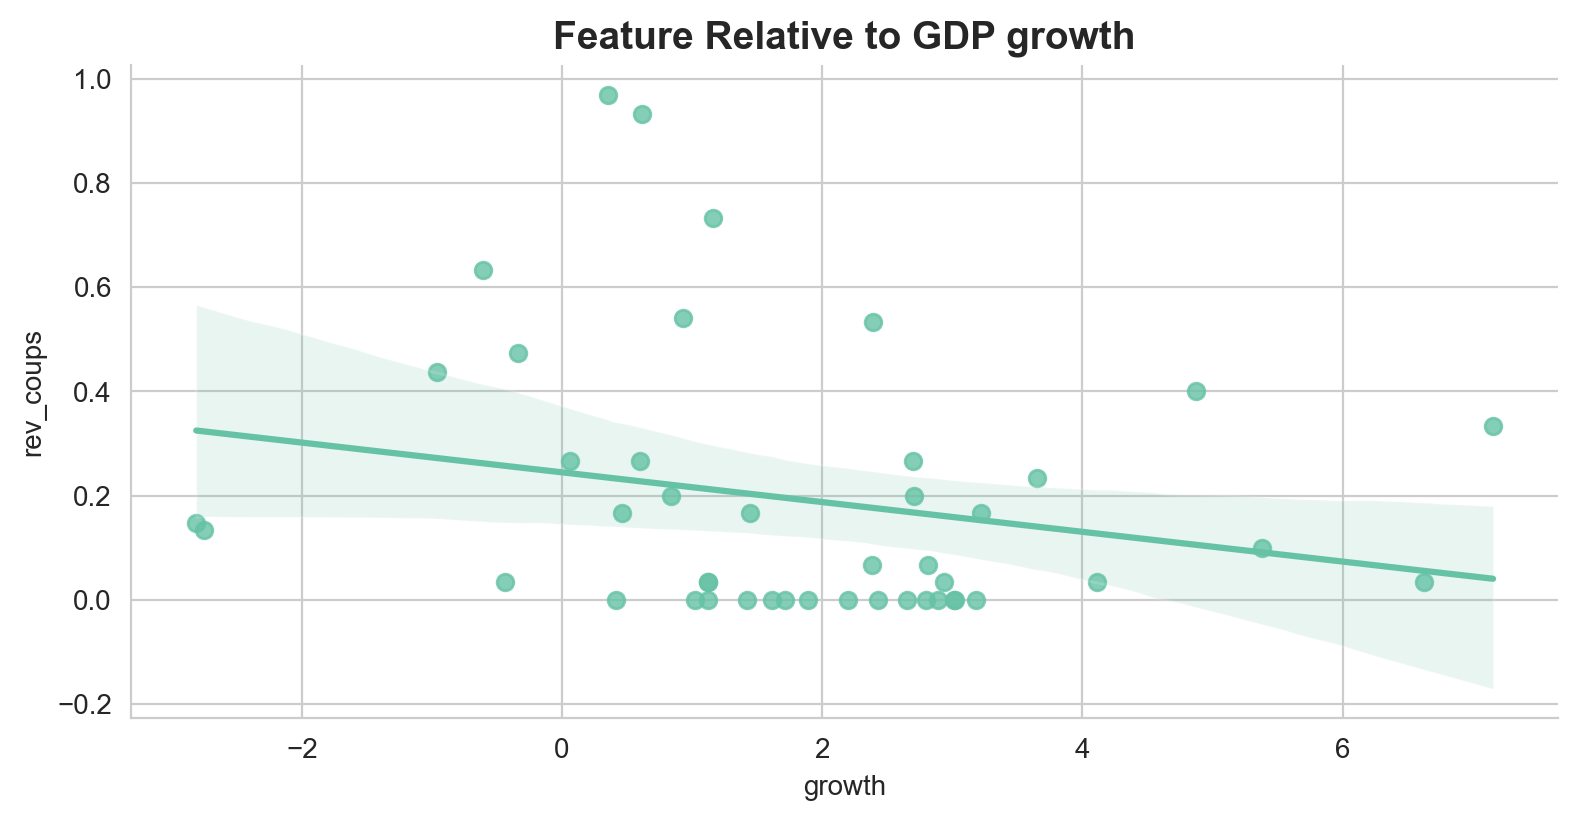

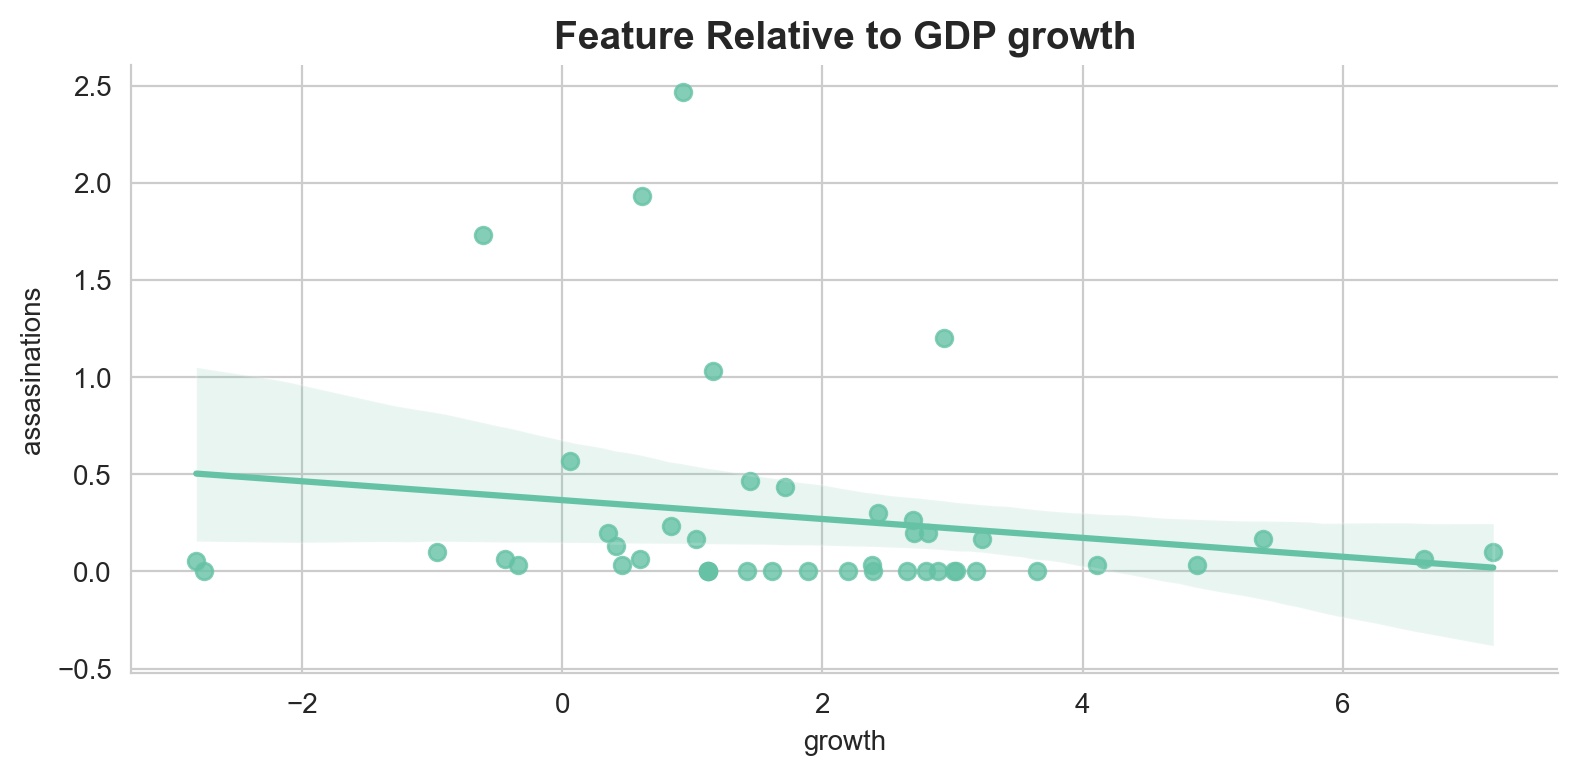

In [195]:
df = train.drop(['country_name', 'oil'], axis=1)

for i, col in enumerate(df.columns.drop('growth')):
    sns.lmplot(x='growth', y=col, data=df, order=1, height=4, aspect=2)
    plt.title(label="Feature Relative to GDP growth", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

3. **Feature Relationships**

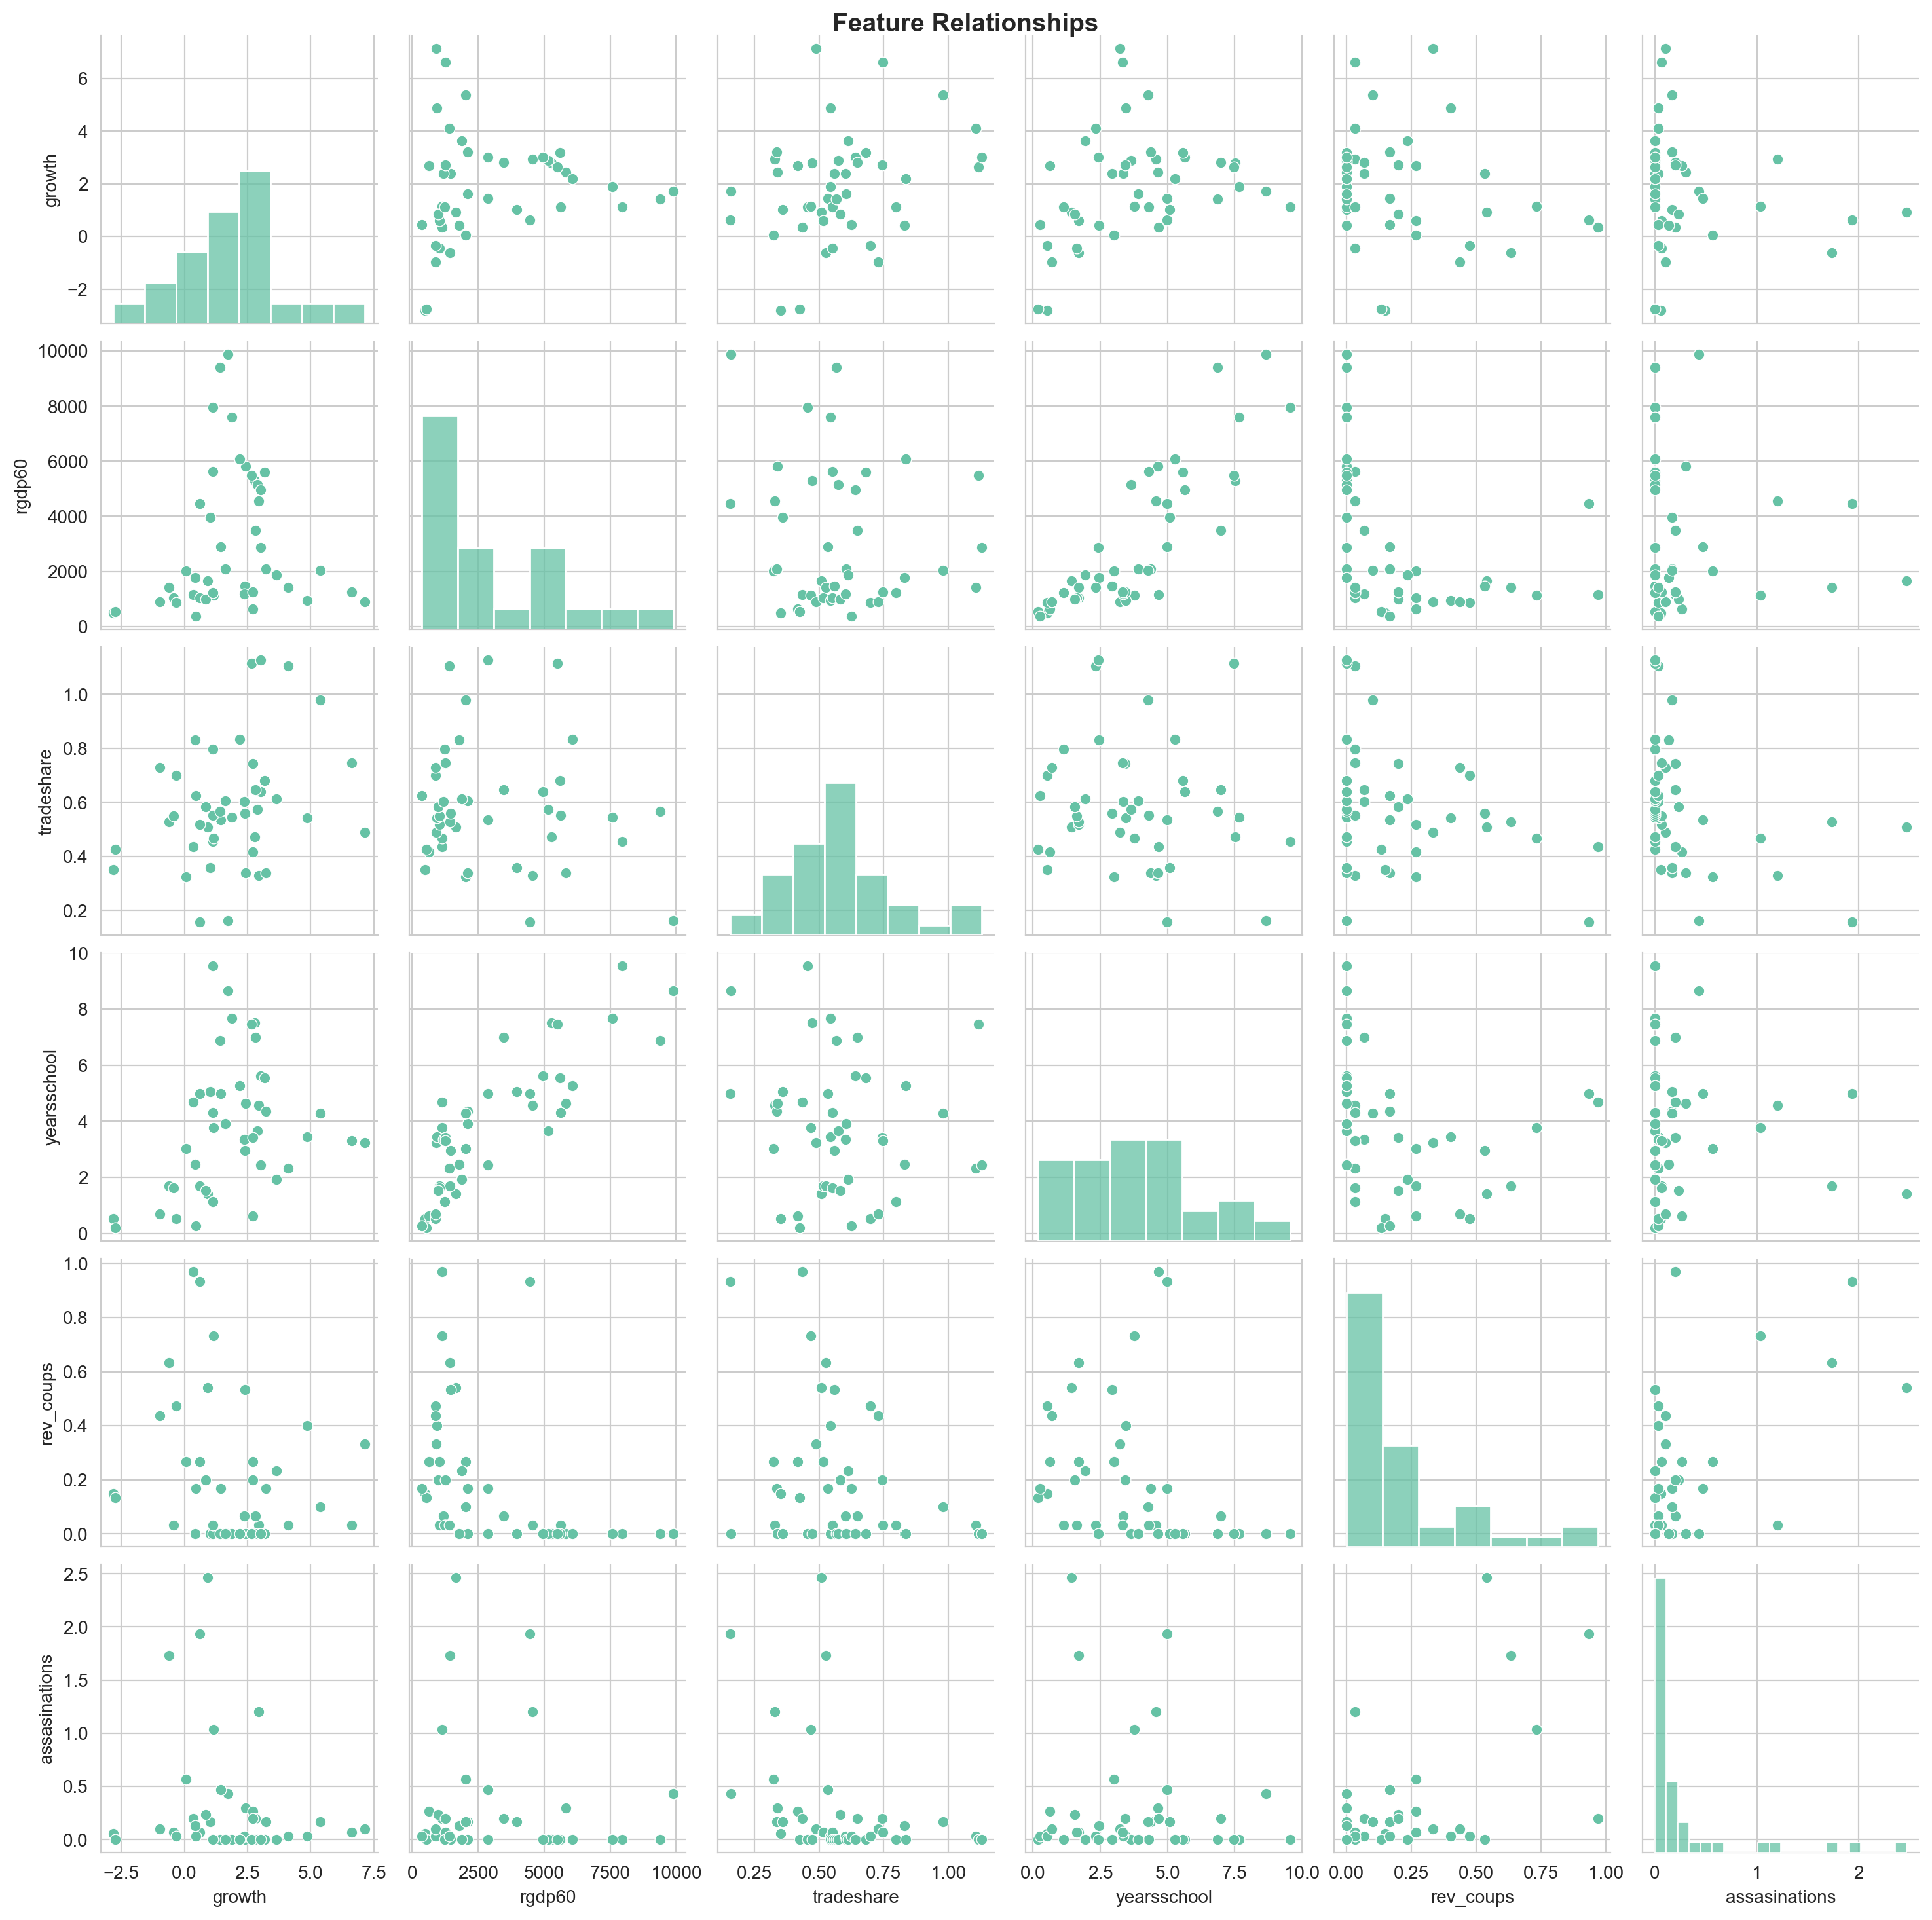

In [196]:
# check feature relationships
df = train.drop(['country_name', 'oil'], axis=1)

g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

g.fig.suptitle("Feature Relationships", fontsize=14, fontweight="bold")
g.tight_layout()

#### Check Feature Correlation

In [197]:
# feature correlation (Pearson Corr)
df = train.drop(['country_name', 'oil'], axis=1)
corr = df.corr()

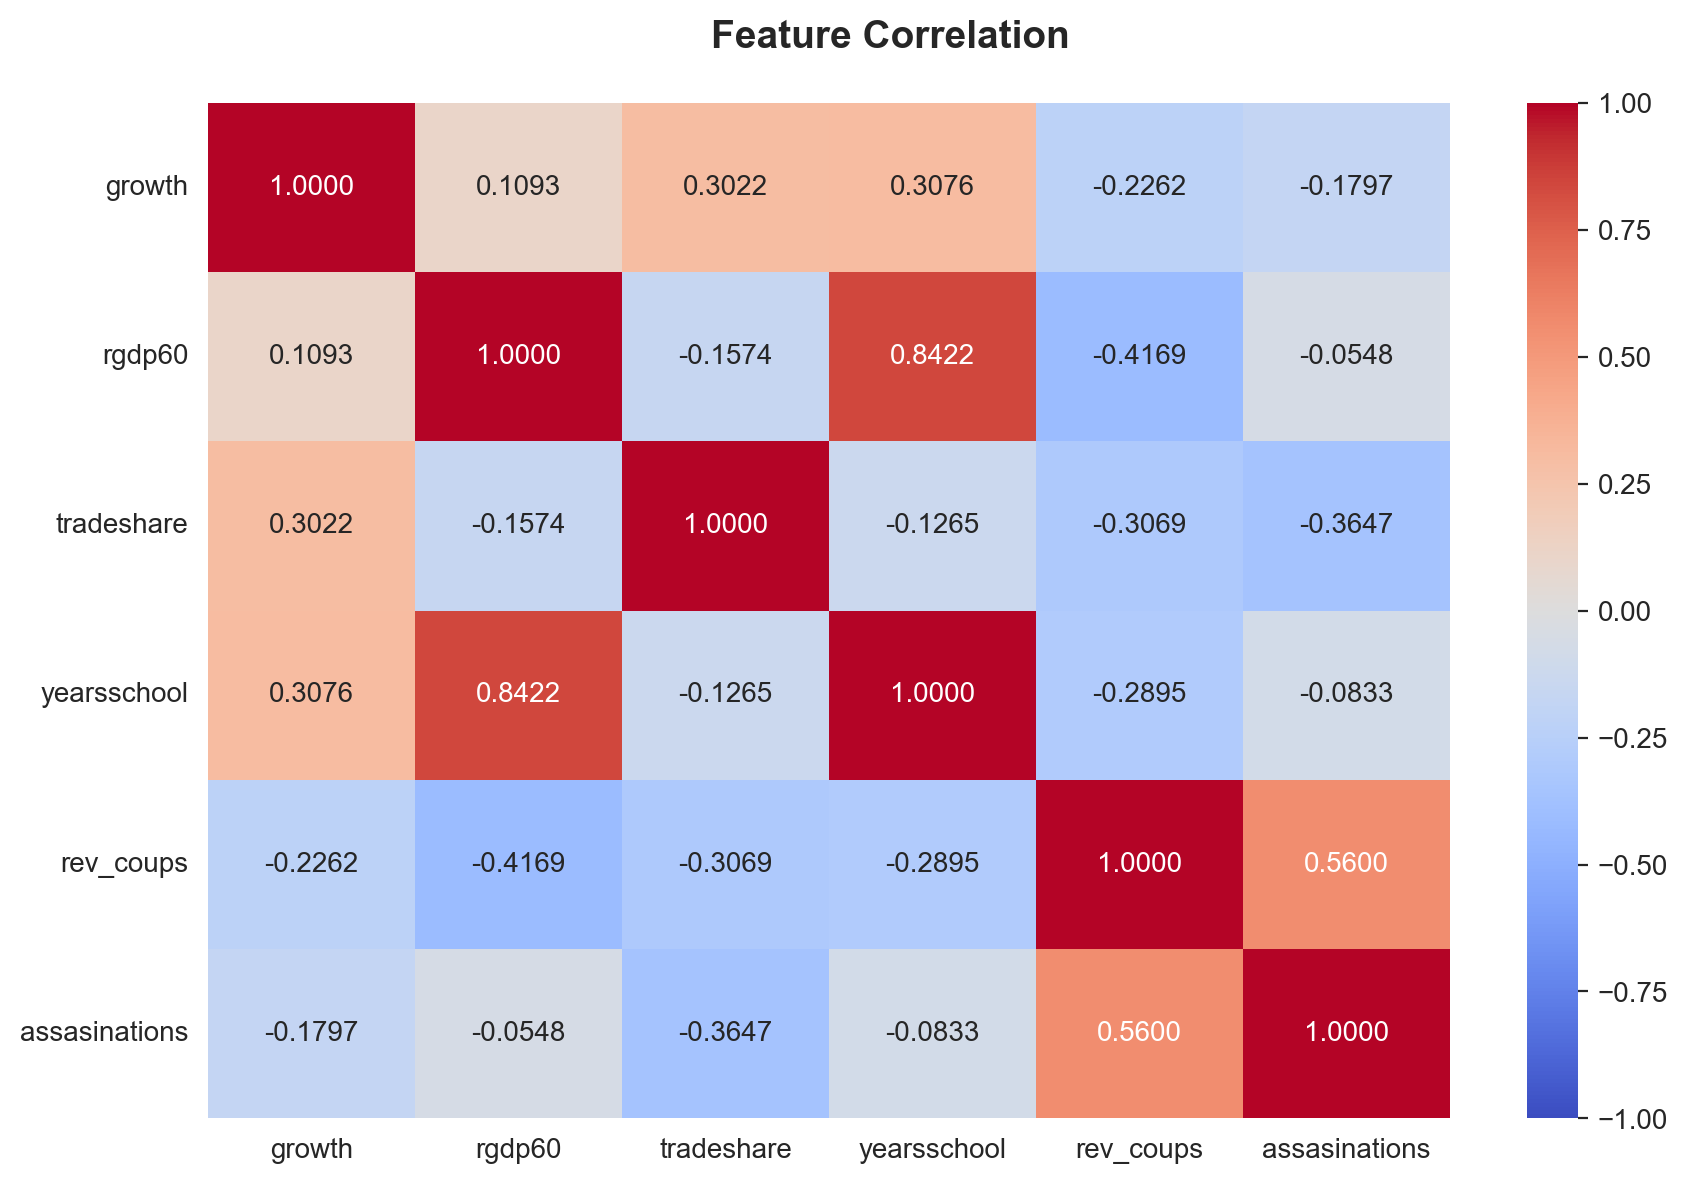

In [198]:
fig = plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".4f", cmap="coolwarm")
fig.suptitle("Feature Correlation", fontsize=14, fontweight="bold")
#plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Findings:
* Very high correlation between ```rgdp60``` & ```yearsschool```: 0.8422. This can also be seen in previous distribution plots. This is not surprising since the GDP growth is highly dependent on the education level of the population. Potentially thinking about only using one of the features or apply another technique to handle high correlation if it has any effect on the model performance.
* High correlation between ```assasinations``` & ```rev_coups```: 0.5600. This can also be seen in previous distribution plots. However, also potentially thinking about only using one of ```rgdp60``` & ```yearsschool``` or apply another technique to handle high correlation if it has any effect on the model performance.
* All other features have the least much than an absolute correlation of 0.1 with the target feature ```growth```. As the threshold for correlation due to the low number of features is set to 0.1, all features are kept for now.

# Data Preprocessing

#### New feature ````region_name```` and ````geopolitical_region_name````

As mentioned before, the feature ```country_name``` can be used to generate a new feature carrying the location information of the country.

In [199]:
# get all country names from holdout set and train set together
countries = pd.concat([train["country_name"], holdout["country_name"]])
unique_countries = countries.unique().tolist()
print(unique_countries)

['Argentina', 'United States', 'Peru', 'Italy', 'Greece', 'France', 'Zaire', 'Uruguay', 'Pakistan', 'Niger', 'Bolivia', 'New Zealand', 'Philippines', 'Finland', 'Korea, Republic of', 'Guatemala', 'Honduras', 'El Salvador', 'Chile', 'Thailand', 'Sweden', 'Senegal', 'Trinidad and Tobago', 'Ecuador', 'Switzerland', 'Austria', 'Zimbabwe', 'Paraguay', 'Costa Rica', 'Portugal', 'Togo', 'Iceland', 'Israel', 'Norway', 'Sierra Leone', 'Ghana', 'Sri Lanka', 'Taiwan, China', 'Papua New Guinea', 'Jamaica', 'Netherlands', 'Cyprus', 'Malaysia', 'Belgium', 'Mauritius', 'India', 'Japan', 'Brazil', 'Bangladesh', 'Spain', 'Colombia', 'Haiti', 'Australia', 'Mexico', 'Germany', 'Canada', 'United Kingdom', 'Venezuela', 'Denmark', 'South Africa', 'Dominican Republic', 'Panama', 'Kenya', 'Ireland', 'Malta']


1. **Mapping the country to a region** -> ```region_name```, ```geopolitical_region_name```

In [200]:
# define a dictionary mapping regions to lists of countries (americas, europe, africa, asia, oceania)
region_to_countries = {
    'Americas': ['Argentina', 'United States', 'Peru', 'Uruguay', 'Bolivia', 'Guatemala', 'Honduras', 'El Salvador', 'Chile', 'Trinidad and Tobago', 'Ecuador', 'Paraguay', 'Costa Rica', 'Jamaica', 'Brazil', 'Colombia', 'Haiti', 'Mexico', 'Venezuela', 'Dominican Republic', 'Panama', 'Canada'],
    'Europe': ['Italy', 'Greece', 'France', 'Finland', 'Sweden', 'Switzerland', 'Austria', 'Portugal', 'Iceland', 'Netherlands', 'Cyprus', 'Belgium', 'Spain', 'Germany', 'United Kingdom', 'Denmark', 'Ireland', 'Malta', 'Norway'],
    'Africa': ['Zaire', 'Niger', 'Senegal', 'Zimbabwe', 'Togo', 'Sierra Leone', 'Ghana', 'Mauritius', 'South Africa', 'Kenya'],
    'Asia': ['Pakistan', 'Philippines', 'Korea, Republic of', 'Thailand', 'Israel', 'Sri Lanka', 'Taiwan, China', 'Malaysia', 'India', 'Japan', 'Bangladesh'],
    'Oceania': ['New Zealand', 'Papua New Guinea', 'Australia']
}

In [201]:
geopolitical_region_to_countries = {
    'Latin America': ['Argentina', 'Peru', 'Uruguay', 'Bolivia', 'Chile', 'Paraguay', 'Brazil', 'Colombia', 'Venezuela', 'Ecuador', 'Guatemala', 'Honduras', 'El Salvador', 'Trinidad and Tobago', 'Haiti', 'Dominican Republic', 'Panama', 'Costa Rica', 'Mexico'],
    'Western Europe': ['Italy', 'Greece', 'France', 'Finland', 'Sweden', 'Switzerland', 'Austria', 'Portugal', 'Iceland', 'Norway', 'Belgium', 'Netherlands', 'Cyprus', 'Spain', 'Ireland', 'Malta', 'United Kingdom', 'Germany', 'Denmark'],
    'Sub-Saharan Africa': ['Zaire', 'Niger', 'Senegal', 'Zimbabwe', 'Togo', 'Sierra Leone', 'Ghana', 'Mauritius', 'Kenya', 'South Africa'],
    'South Asia': ['Pakistan', 'India', 'Bangladesh', 'Sri Lanka'],
    'East Asia': ['Korea, Republic of', 'Thailand', 'Taiwan, China', 'Japan'],
    'Southeast Asia': ['Philippines', 'Malaysia'],
    'Caribbean': ['Trinidad and Tobago', 'Jamaica', 'Haiti'],
    'North America': ['United States', 'Canada'],
    'Oceania': ['New Zealand', 'Australia'],
    'Middle East': ['Israel'],
    'Pacific': ['Papua New Guinea']
}

In [202]:
# create a reverse mapping dictionary (country to region)
country_to_region = {country: region for region, countries in region_to_countries.items() for country in countries}
country_to_geopolitical_region = {country: region for region, countries in geopolitical_region_to_countries.items() for country in countries}

In [203]:
# check if all countries from the data are listed in the dictionary
def check_countries(country_ls, country_to_region):
    countries_not_listed = [country for country in country_ls if country not in country_to_region]
    if countries_not_listed:
        print("The following countries are not listed in the country_to_region dictionary:")
        print(countries_not_listed)
        return False
    return True

In [204]:
check_countries(unique_countries, country_to_region)
check_countries(unique_countries, country_to_geopolitical_region)

True

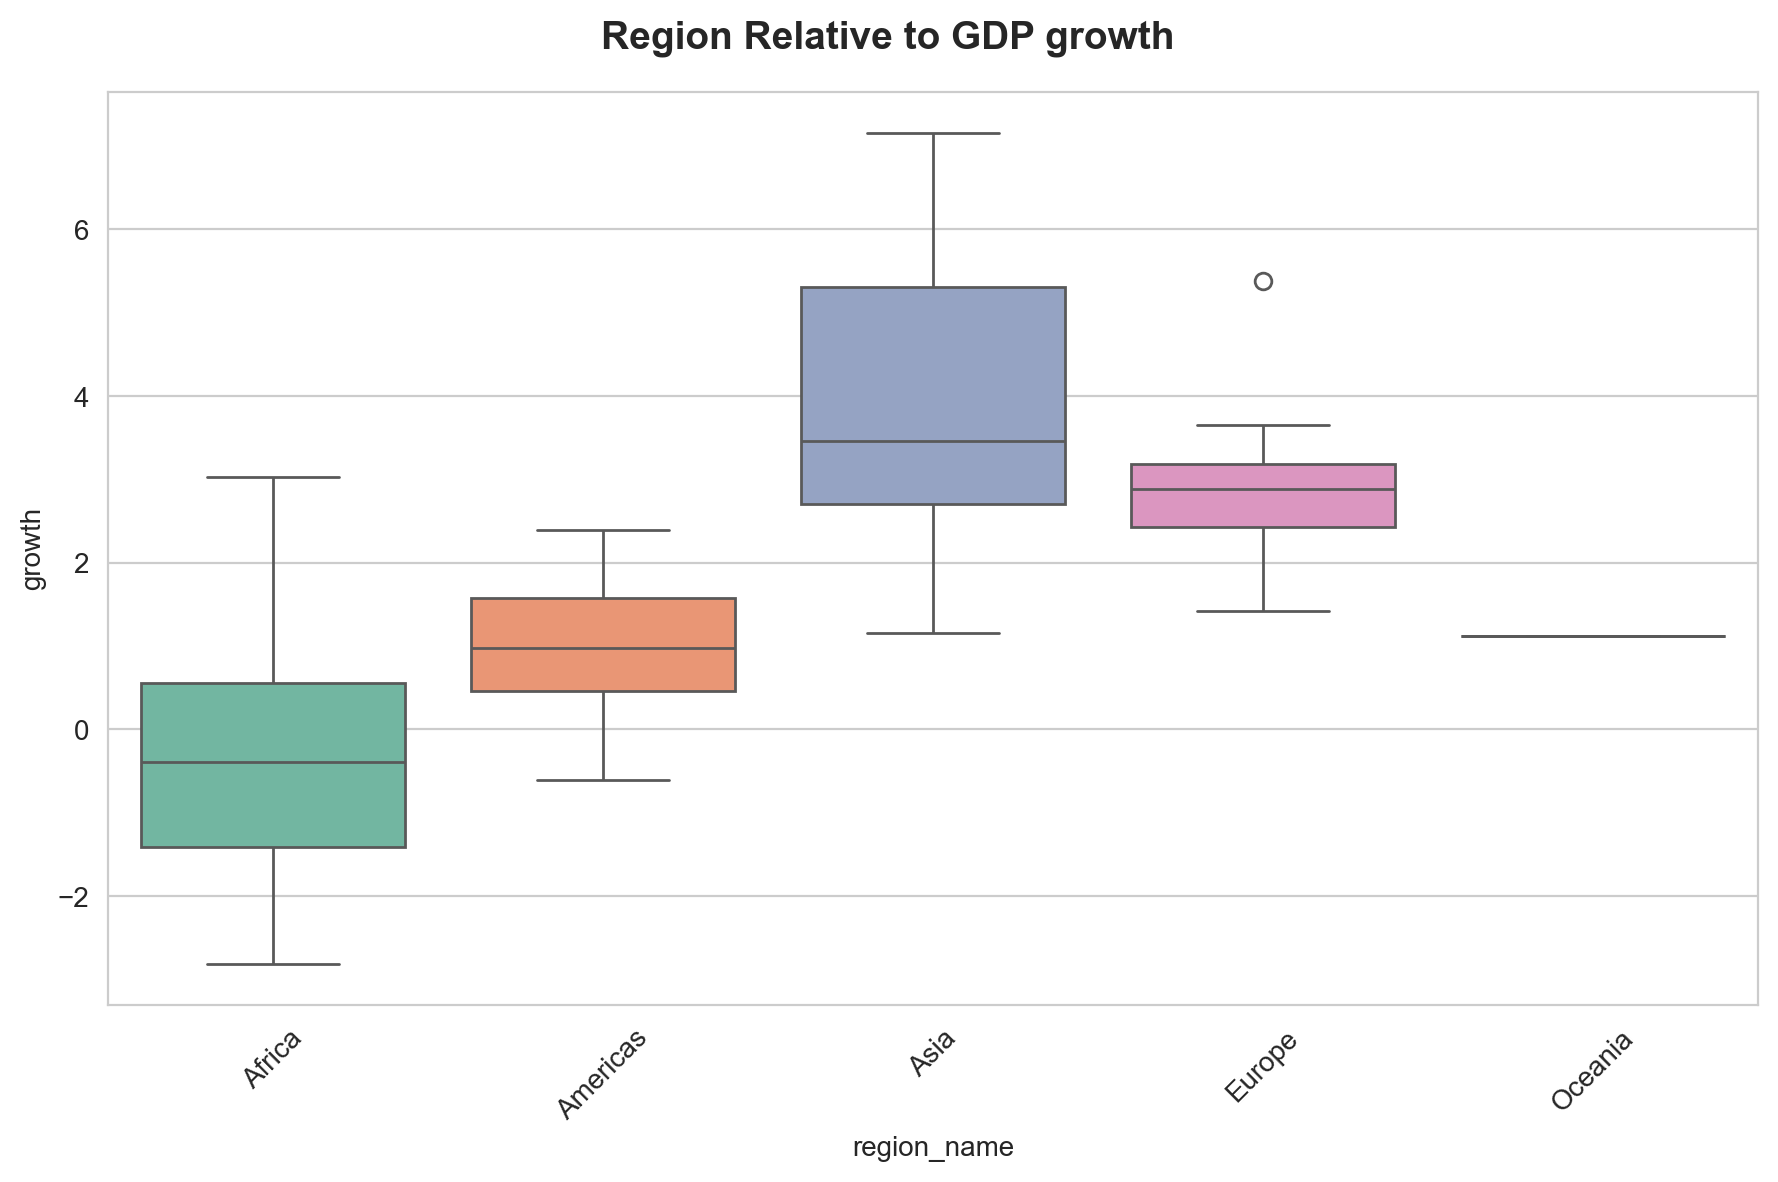

In [205]:
# plot the correlation between the new feature and the target in plot with hue
df = train.copy()
df["region_name"] = df["country_name"].map(country_to_region)
df["region_name"] = df["region_name"].astype("category")

fig = plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x="region_name", y="growth", hue="region_name")
fig.suptitle("Region Relative to GDP growth", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

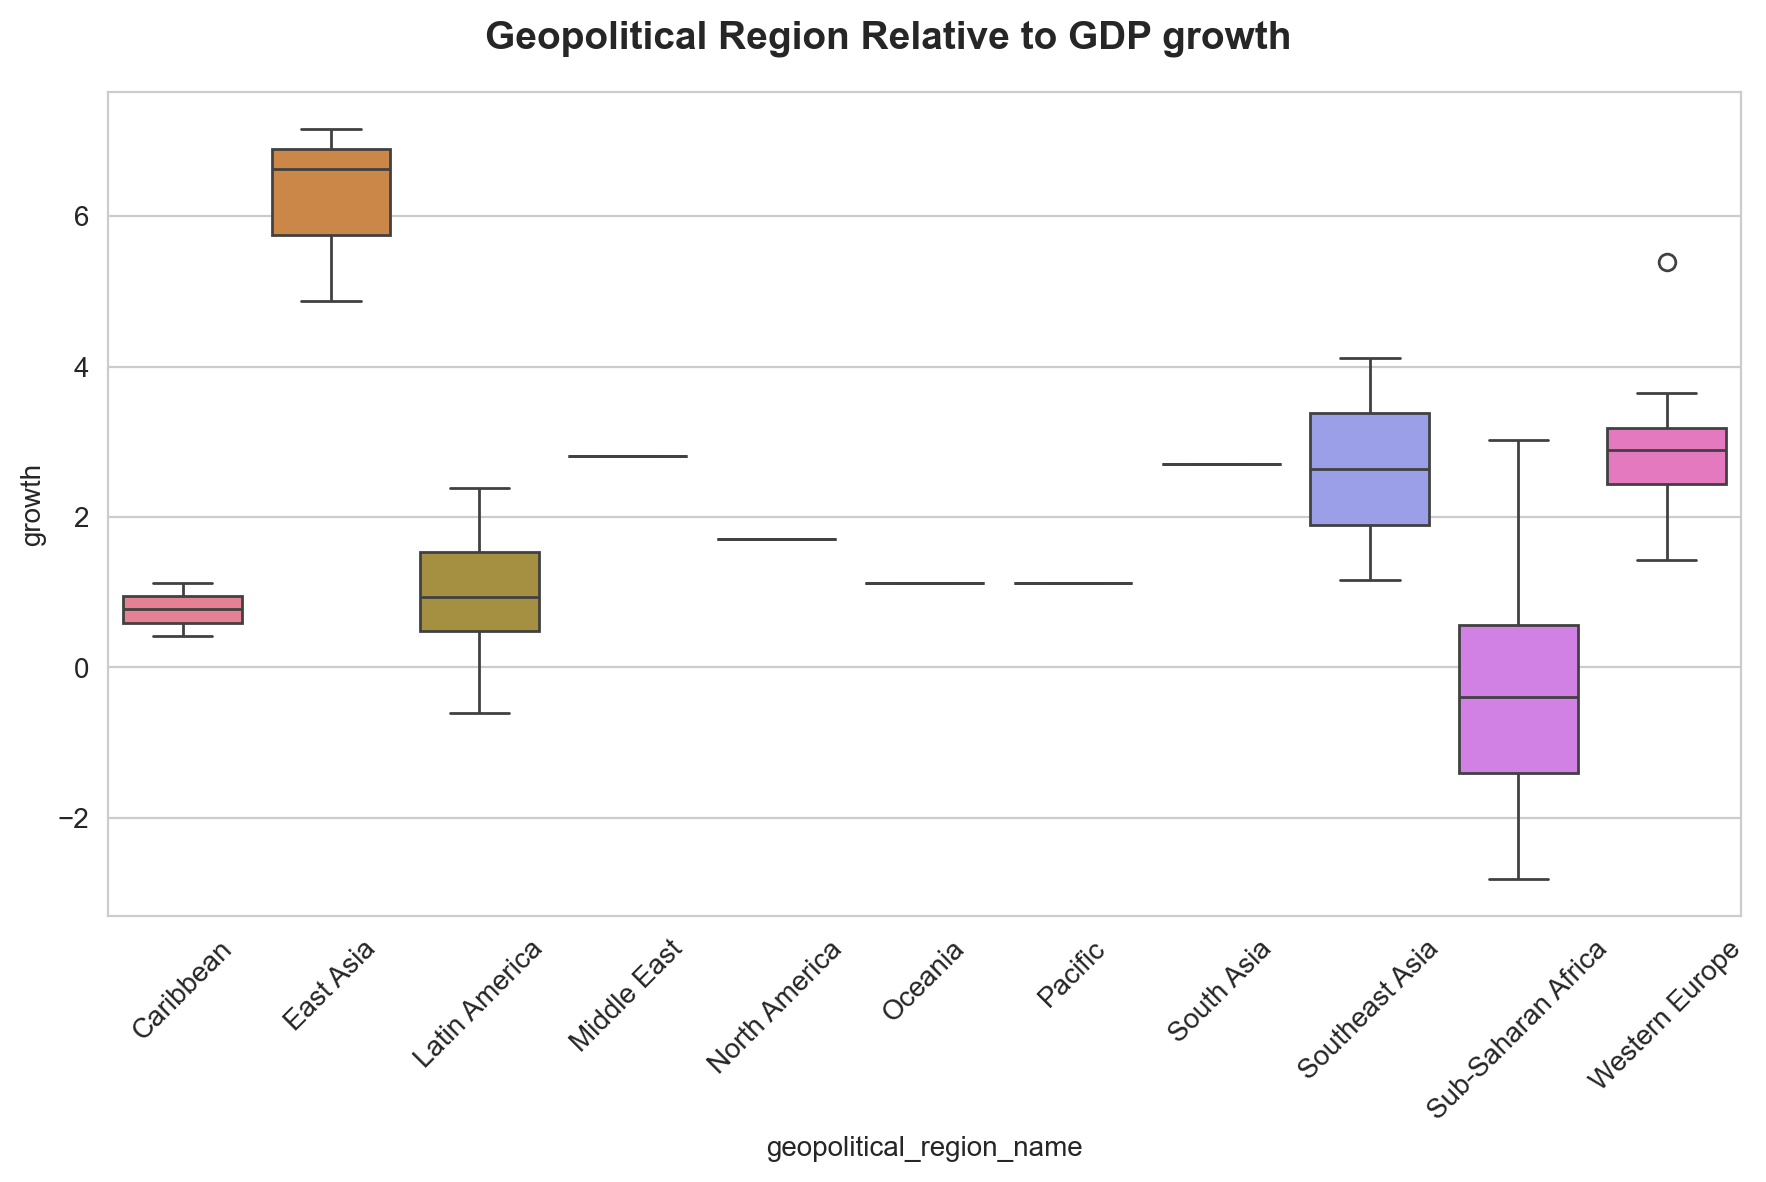

In [206]:
df["geopolitical_region_name"] = df["country_name"].map(country_to_geopolitical_region)
df["geopolitical_region_name"] = df["geopolitical_region_name"].astype("category")

fig = plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x="geopolitical_region_name", y="growth", hue="geopolitical_region_name")
fig.suptitle("Geopolitical Region Relative to GDP growth", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [207]:
# plot the relation between avg years of schooling and GDP growth
fig = px.scatter(df, x="yearsschool", y="growth", color="region_name", title="<b>Avg Years of Schooling Relative to GDP growth</b>").update_layout(width=750, height=500, showlegend=True, title_font_size=14)
fig.show(observer=True)

C:\Users\merti\anaconda3\envs\py310\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Findings:
* The ````region_name```` feature seems to have a correlation with the target feature ```growth```, as assumed and seen in the boxplot. The region feature is kept for further preprocessing. (Note: Has made positive impact on the model performance with decreasing the MAE about > -0.2)
* As no surprise the years of schooling also has a relation with the region and thus since it has a high correlation with the target feature ```growth```, also has high impact as can be seen in the scatter plot and the correlation matrix.
* Deciding to keep the feature ```region_name``` or ```geopolitical_region_name``` is based on the model performance. The feature with the better performance will be kept. Both are no option since they are highly correlated with each other. (Note: Best performance with ```geopolitical_region_name```: MAE 0.44, ```region_name```: MAE 0.48)

2. **Longitude and Latitude Information** -> ```longitude```, ```latitude```

TBD

3. **Summarize in function**

In [ ]:
def

#### Synthetic Data via Data Augmentation with (Gaussian) Noise
Additional synthetic samples are created by adding noise to existing samples. This can help increase the diversity the dataset, and also up-samples the data since it is a small dataset.

In [208]:
def add_noise(dataframe, column, std=None, noise_threshold=3):

    if std is None:
        std = dataframe[column].std()

    # ensure the noise doesn't push the feature value out of range
    max_noise = noise_threshold * std
    # generate Gaussian noise within the specified threshold
    noise = np.random.normal(0, max_noise, len(dataframe))
    # add noise to the column
    dataframe[column] = dataframe[column] + noise

    return dataframe

In [209]:
def generate_augmented_data(dataframe, num_duplicates, noise_std=0.1):
    # duplicate the data by sampling with replacement (bootstrapping) and concatenate the samples so for example 200 duplicates are created in total
    duplicated_data = dataframe.sample(n=num_duplicates, replace=True, random_state=42)
    # add noise to each duplicate (if the feature is numeric, otherwise skip)
    for column in dataframe.columns:
        if dataframe[column].dtype in ['int64', 'float64']:
            duplicated_data = add_noise(duplicated_data, column, std=noise_std)
    # concatenate original and augmented data
    return pd.concat([dataframe, duplicated_data])

In [210]:
# X_train_augmented = generate_augmented_data(X_train, num_duplicates=200, noise_std=0.1)

#### Summary of preprocessing steps:

In [247]:
def preprocess(data, target_column, standardize, ohe, columns_to_drop, region_features, augmented_data):

    # drop irrelevant features
    train = data.drop(columns_to_drop, axis=1)
    train_preprocessed = train.copy()

    if augmented_data:
        # add augmented data
        train_preprocessed = generate_augmented_data(train_preprocessed, num_duplicates=augmented_data, noise_std=0.1)

    if region_features:
        if 'region_name' in region_features:
            # Add region_name column based on the mapping
            train_preprocessed['region_name'] = train_preprocessed['country_name'].map(country_to_region)
            train_preprocessed['region_name'] = train_preprocessed['region_name'].astype('category')
        if 'geopolitical_region_name' in region_features:
            # Add geopolitical_region_name column based on the mapping
            train_preprocessed['geopolitical_region_name'] = train_preprocessed['country_name'].map(country_to_geopolitical_region)
            train_preprocessed['geopolitical_region_name'] = train_preprocessed['geopolitical_region_name'].astype('category')
        # Drop the country_name column
        train_preprocessed.drop(columns=['country_name'], inplace=True)

    if ohe:
        # encoding categorical features
        categorical_clos = train_preprocessed.select_dtypes(include=['category'])
        train_preprocessed = pd.get_dummies(train_preprocessed, columns=categorical_clos.columns)

    if target_column:
        y = train_preprocessed[target_column]
        X = train_preprocessed.drop(target_column, axis=1)
        return X, y
    else:
        X = train_preprocessed
        return X

In [280]:
X_train_preprocessed, y_train = preprocess(train, TARGET, STANDARDIZE, OHE, FEATURES_TO_DROP, REGION_FEATURES, AUGMENTED_DATA)
X_holdout_preprocessed = preprocess(holdout, None, STANDARDIZE, OHE, FEATURES_TO_DROP, REGION_FEATURES, None)

In [281]:
if STANDARDIZE:
    numeric_cols = X_train_preprocessed.select_dtypes(include=['number'])
    scaler = StandardScaler()
    X_train_preprocessed[numeric_cols.columns] = scaler.fit_transform(numeric_cols)
    X_holdout_preprocessed[numeric_cols.columns] = scaler.transform(X_holdout_preprocessed[numeric_cols.columns])

In [282]:
print("Shape of X_train_processed:", X_train_preprocessed.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_holdout_processed:", X_holdout_preprocessed.shape)

Shape of X_train_processed: (195, 10)
Shape of y_train: (195,)
Shape of X_holdout_processed: (20, 10)


In [251]:
X_train_preprocessed.head(10)

,rgdp60,tradeshare,yearsschool,rev_coups,assasinations,region_name_Africa,region_name_Americas,region_name_Asia,region_name_Europe,region_name_Oceania
Id,,,,,,,,,,
1,0.534465,-1.172355,0.477857,2.081004,2.925987,False,True,False,False,False
4,2.686548,-1.160916,1.994080,-0.482661,0.342639,False,True,False,False,False
8,-0.433240,-0.713975,-0.336028,0.249815,0.572270,False,True,False,False,False
11,0.574868,-0.699216,0.300207,-0.391102,1.663017,False,False,False,True,False
12,-0.403928,-0.677777,0.221711,-0.024864,-0.116622,False,False,False,True,False
13,1.073574,-0.672791,0.337390,-0.482661,0.113009,False,False,False,True,False
14,-1.039293,-0.638379,-1.360614,-0.075730,-0.307981,True,False,False,False,False
15,0.338784,-0.620537,0.510909,-0.482661,-0.116622,False,True,False,False,False
17,-0.980272,-0.460238,-1.323432,0.249815,0.055601,False,False,True,False,False


# Feature Selection

In [252]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train_preprocessed, y_train)
mi_scores = pd.DataFrame(mutual_info, index=X_train_preprocessed.columns, columns=["mutual_info"])
mi_scores = mi_scores.sort_values(by="mutual_info", ascending=False)

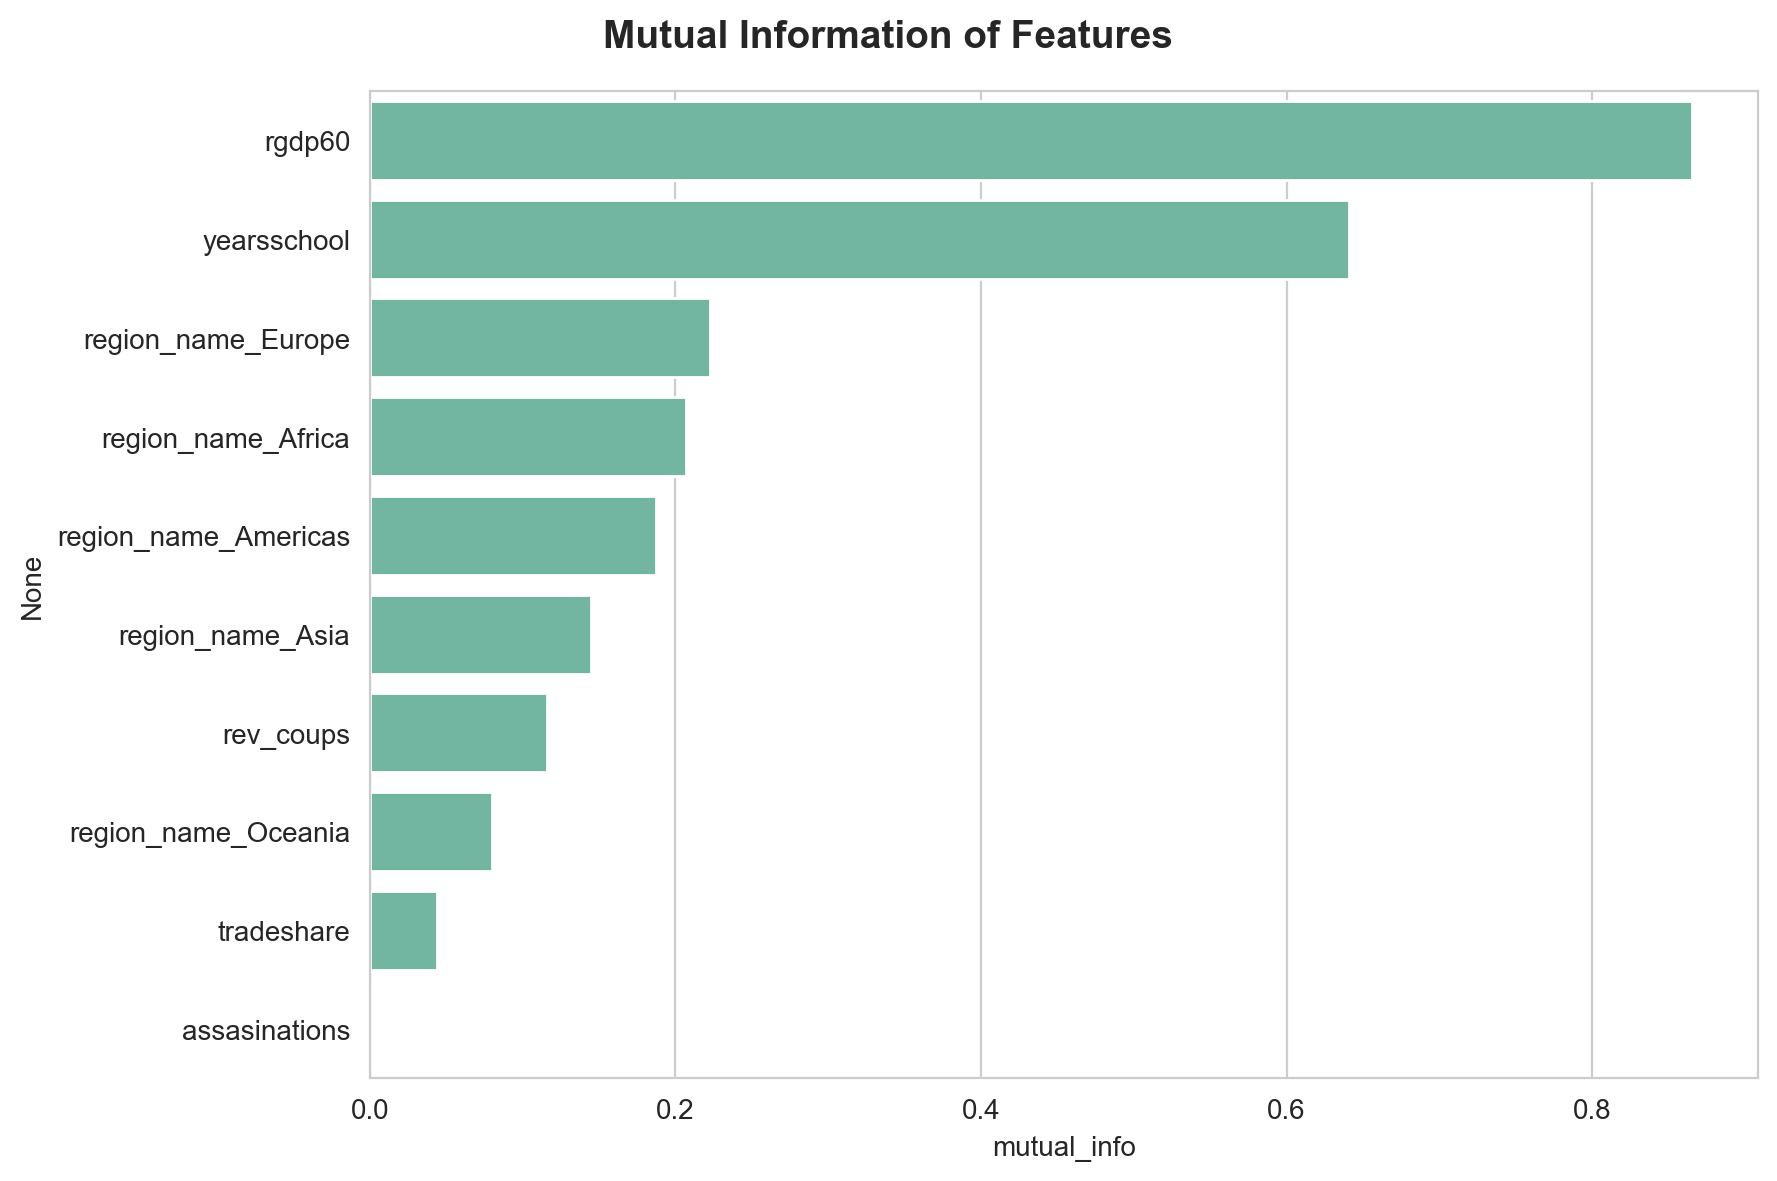

In [253]:
fig = plt.figure(figsize=(9, 6))
sns.barplot(data=mi_scores, x="mutual_info", y=mi_scores.index)
fig.suptitle("Mutual Information of Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [254]:
# select the top k features
selected_features = mi_scores.head(K).index.tolist()
print(selected_features)

['rgdp60', 'yearsschool', 'region_name_Europe', 'region_name_Africa', 'region_name_Americas', 'region_name_Asia', 'rev_coups', 'region_name_Oceania', 'tradeshare', 'assasinations']


In [255]:
# drop the features that are not selected
X_train_preprocessed = X_train_preprocessed[selected_features]
X_holdout_preprocessed = X_holdout_preprocessed[selected_features]

# Train Test Split

In [295]:
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X_train_preprocessed, y_train, train_size=0.8, shuffle=True, random_state=42)

# 1. Train Regression Models

#### Model Selection

In [257]:
# select regression models to be evaluated
models = {
    # Tree models
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    # Ensemble models
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    # Linear models
    "ElasticNet": ElasticNet(random_state=42, alpha=1.0, l1_ratio=0.5),
    "SVR": SVR(),
    "BayesianRidge": BayesianRidge(),
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0),
    # Other models
    "CatBoostRegressor": CatBoostRegressor(random_state=42, verbose=False),
    "XGBRegressor": XGBRegressor(random_state=42, n_jobs=-1)
}

#### Cross-Validation of Models

In [258]:
# run experiment
def fit_and_predict(models, X_train, y_train):
    """
    Fit on train data and predict on holdout data.

    :param models: Dictionary of models to be evaluated.
    :type models: dict
    :param X_train: Train data.
    :type X_train: pandas.core.frame.DataFrame
    :param y_train: Train target.
    :type y_train: pandas.core.frame.DataFrame

    """
    predictions = {}
    fitted_models = {}
    scores = {}

    # transform y_train to 1D numpy array in order to fit the models if needed
    if type(y_train) is not np.ndarray:
        y_train = y_train.values.ravel()

    # progress bar for the loop
    progress_bar = tqdm(models.items(), desc="Models", leave=False)

    for model_name, model in progress_bar:
        print("="*50)
        print(f"Evaluating {model_name}...")

        # start the timer
        start_time = time.time()

        # perform 10-fold cross-validation (or LOOCV with using n_splits=45=#samples)
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_scores = []
        cv_predictions = []

        for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train)):
            print(f"Fold {fold_idx + 1}/5")
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # fit the model
            model.fit(X_train_fold, y_train_fold)
            fitted_models[model_name] = model

            # predict on validation fold
            fold_predictions = model.predict(X_val_fold)
            cv_predictions.append(fold_predictions)

            # calculate MAE for the fold
            fold_mae = mean_absolute_error(y_val_fold, fold_predictions)
            print(f"MAE for fold {fold_idx + 1}: {fold_mae}")
            fold_scores.append(fold_mae)

        # end the timer
        end_time = time.time()

        # calculate the fit time
        fit_time = end_time - start_time
        print(f"Fit Time ({model_name}): {fit_time:.2f} seconds")

        # store fold-wise scores and predictions
        predictions[model_name] = predictions
        scores[model_name] = fold_scores

    return predictions, fitted_models, scores

In [259]:
%%time
predictions, fitted_models, scores = fit_and_predict(models, X_train_preprocessed, y_train)

Models:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating DecisionTreeRegressor...
Fold 1/5
MAE for fold 1: 0.5766270891666727
Fold 2/5
MAE for fold 2: 0.7235577709619937
Fold 3/5
MAE for fold 3: 1.3022714519606302
Fold 4/5
MAE for fold 4: 0.8225303062762024
Fold 5/5
MAE for fold 5: 1.3243602691805936
Fold 6/5
MAE for fold 6: 0.7480119040494024
Fold 7/5
MAE for fold 7: 0.6242748006094202
Fold 8/5
MAE for fold 8: 0.9459961400067475
Fold 9/5
MAE for fold 9: 0.3169965918786163
Fold 10/5
MAE for fold 10: 0.37316429793686884
Fit Time (DecisionTreeRegressor): 0.07 seconds
Evaluating RandomForestRegressor...
Fold 1/5
MAE for fold 1: 0.4896797692829793
Fold 2/5
MAE for fold 2: 0.42895266782783686
Fold 3/5
MAE for fold 3: 0.8273865886150618
Fold 4/5
MAE for fold 4: 0.5736019749335594
Fold 5/5
MAE for fold 5: 0.8019352573806448
Fold 6/5
MAE for fold 6: 0.5902351423770457
Fold 7/5
MAE for fold 7: 0.5378911854295286
Fold 8/5
MAE for fold 8: 0.6426481967125409
Fold 9/5
MAE for fold 9: 0.5559704408409738
Fold 10/5
MAE for fold 10: 0.413489536271

#### Evaluate the CV Results

In [260]:
# get scores as df
results = []
for model_name, mae_scores in scores.items():
    for fold, mae in enumerate(mae_scores, start=1):
        results.append({'model_name': model_name, 'mae': mae, 'fold': fold})

scores_df = pd.DataFrame(results)
scores_df["mean_mae"] = scores_df.groupby('model_name')['mae'].transform('mean')
scores_df = scores_df.sort_values(by=["mean_mae"], ascending=True).reset_index(names=["model"])

In [261]:
scores_df.head(10)

,model,model_name,mae,fold,mean_mae
0,24,ExtraTreesRegressor,0.524205,5,0.500713
1,29,ExtraTreesRegressor,0.329608,10,0.500713
2,28,ExtraTreesRegressor,0.419847,9,0.500713
3,27,ExtraTreesRegressor,0.533459,8,0.500713
4,26,ExtraTreesRegressor,0.481538,7,0.500713
5,25,ExtraTreesRegressor,0.573039,6,0.500713
6,23,ExtraTreesRegressor,0.632600,4,0.500713
7,22,ExtraTreesRegressor,0.702498,3,0.500713
8,21,ExtraTreesRegressor,0.418272,2,0.500713
9,20,ExtraTreesRegressor,0.392059,1,0.500713


In [263]:
# save scores
timestamp = time.strftime("%Y%m%d-%H%M%S")
scores_df.to_csv(f"../../data/processed/ex1_growth_cv5_{timestamp}_st{STANDARDIZE}_ohe{OHE}_reg{REGION_FEATURES}_K{K}.csv", index=False)

**Visualize the results**

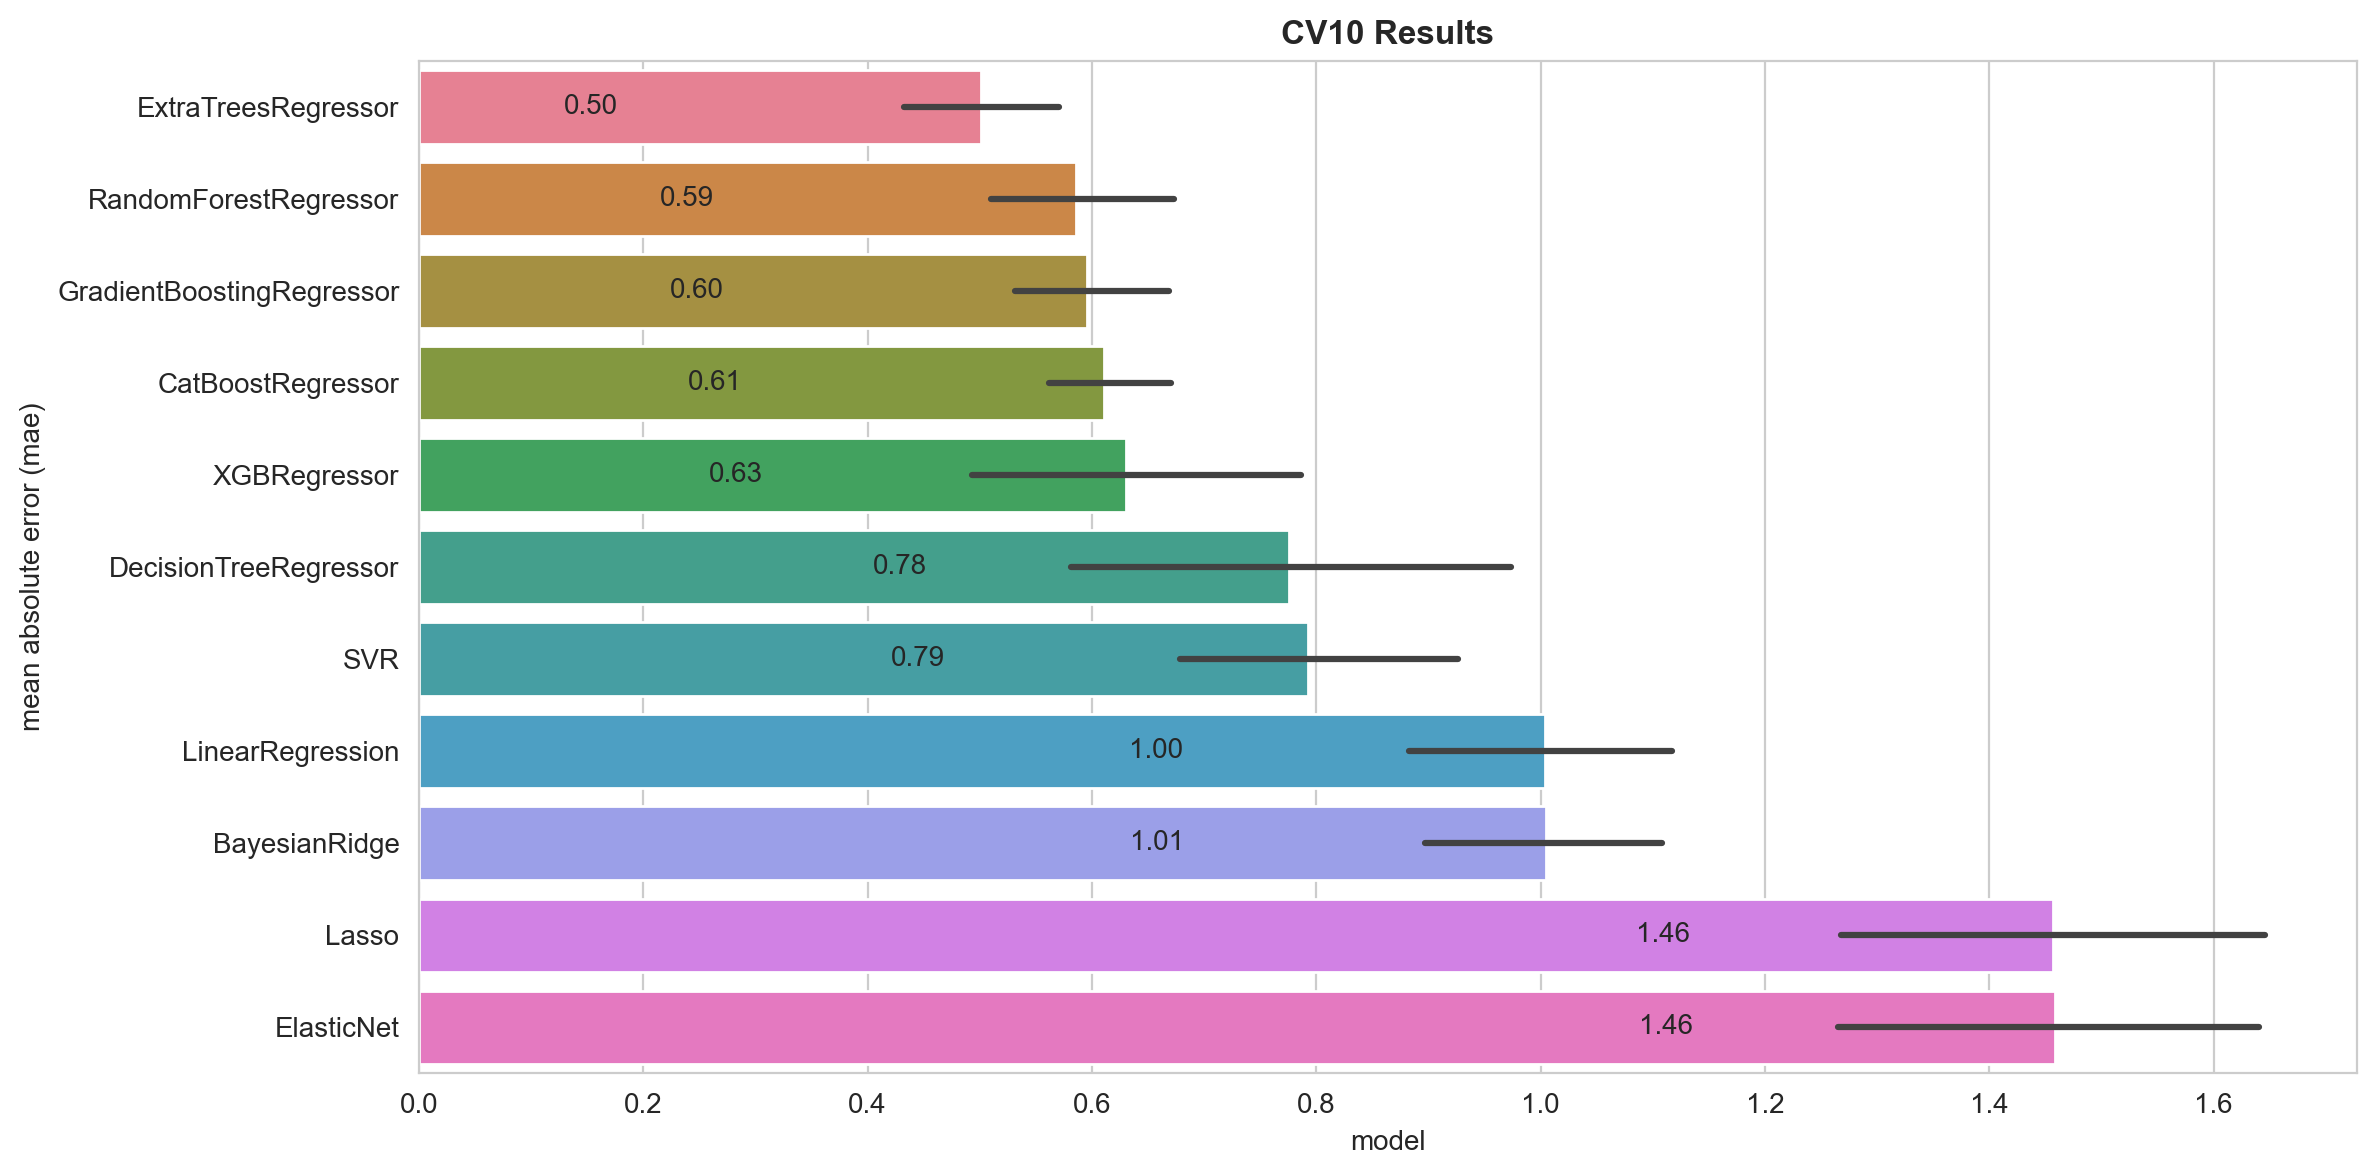

In [264]:
# Create the bar plots with the sorted DataFrame
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=scores_df, x="mae", y="model_name", ax=ax, hue="model_name", legend=False)
#plt.axvline(x=0.787, color="red", linestyle="--", label="0.787 baseline (pairwise)")
# plot legend on top above the diagrams
#plt.text(3.6, 0.8, '0.787 baseline', fontsize=10, color="red")

ax.set_title("CV10 Results", fontweight="bold")
ax.set_ylabel("mean absolute error (mae)")
ax.set_xlabel("model")
for i in range(len(scores_df["model_name"].unique())):
    ax.bar_label(ax.containers[i], fmt='%.2f', padding=-150, fontsize=10)

fig.tight_layout()
plt.show()

In [265]:
# save plot
timestamp = time.strftime("%Y%m%d-%H%M%S")
fig.savefig(f"../../docs/ex1_growth_cv5_{timestamp}_st{STANDARDIZE}_ohe{OHE}_reg{REGION_FEATURES}_K{K}.png")

# 2. Train Neural Network

In [266]:
# convert Pandas DataFrames to TensorFlow tensors
X_train_t = tf.constant(X_train_preprocessed.values, dtype=tf.float32)
y_train_t = tf.constant(y_train.values, dtype=tf.float32)
X_test_t = tf.constant(X_test_preprocessed.values, dtype=tf.float32)
y_test_t = tf.constant(y_test.values, dtype=tf.float32)

In [338]:
# define NN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_t.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=['mean_absolute_error', 'mean_squared_error'])

In [339]:
# train
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train_t, y_train_t, epochs=400, validation_split=0.2) #, callbacks=[early_stopping])

Epoch 1/300
5/5 [==============================] - 2s 51ms/step - loss: 2.2767 - val_loss: 2.0130
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 2.1056 - val_loss: 1.9977
Epoch 3/300
5/5 [==============================] - 0s 12ms/step - loss: 2.0676 - val_loss: 1.9832
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 2.0825 - val_loss: 1.9570
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 1.9599 - val_loss: 1.9281
Epoch 6/300
5/5 [==============================] - 0s 12ms/step - loss: 1.8735 - val_loss: 1.8949
Epoch 7/300
5/5 [==============================] - 0s 12ms/step - loss: 1.8377 - val_loss: 1.8576
Epoch 8/300
5/5 [==============================] - 0s 8ms/step - loss: 1.8077 - val_loss: 1.8282
Epoch 9/300
5/5 [==============================] - 0s 8ms/step - loss: 1.8137 - val_loss: 1.8003
Epoch 10/300
5/5 [==============================] - 0s 12ms/step - loss: 1.7296 - val_loss: 1.7727
Epoch 11/300
5/5 [=====

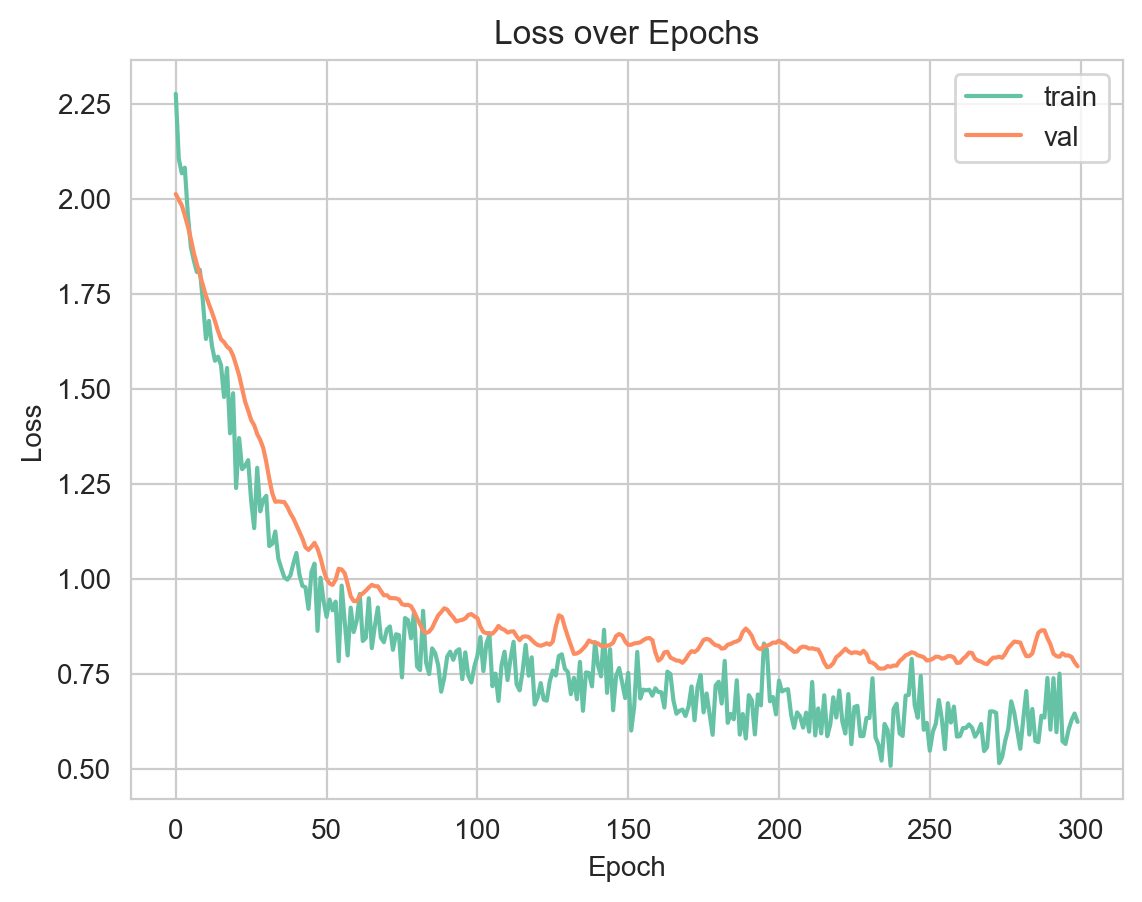

In [340]:
# plot loss
sns.lineplot(data=history.history['loss'], label='train')
sns.lineplot(data=history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()

# Hyperparameter Optimization using GridSearchCV


### CatBoostRegressor

In [270]:
# define hyperparameters
param_grid = {
    "iterations": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5]
}

In [271]:
%%time
# create grid search
grid_search_cat = GridSearchCV(estimator=CatBoostRegressor(random_state=42, verbose=False), param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
# execute search
result = grid_search_cat.fit(X_train_preprocessed, y_train)
# summarize result
print("="*50)
print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)
print("Best estimators:", grid_search_cat.best_estimator_)

Best Score: -0.6094420431418615
Best Hyperparameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.3}
Best estimators: <catboost.core.CatBoostRegressor object at 0x000001A801F48B50>
CPU times: total: 7.59 s
Wall time: 5min 43s


#### RandomForestRegressor

In [272]:
# define hyperparameters
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

In [273]:
%%time
# create grid search
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
# execute search
result = grid_search_rf.fit(X_train_preprocessed, y_train)
# summarize result
print("="*50)
print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)
print("Best estimators:", grid_search_rf.best_estimator_)


Best Score: -0.616505233186822
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best estimators: RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)
CPU times: total: 5.12 s
Wall time: 1min 26s


#### ExtraTreesRegressor


In [274]:
# define hyperparameters
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

In [291]:
%%time
# create grid search
grid_search_et = GridSearchCV(estimator=ExtraTreesRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
# execute search
result = grid_search_et.fit(X_train_preprocessed, y_train)
# summarize result
print("="*50)
print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)
print("Best estimators:", grid_search_et.best_estimator_)


Best Score: -0.45618581643300626
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best estimators: ExtraTreesRegressor(max_depth=10, n_estimators=300, n_jobs=-1, random_state=42)
CPU times: total: 2.41 s
Wall time: 43.1 s


# Evaluate the best model on Test Set

In [336]:
y_pred_cat = grid_search_cat.best_estimator_.predict(X_test_preprocessed)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test_preprocessed)
y_pred_et = grid_search_et.best_estimator_.predict(X_test_preprocessed)
y_pred_nn = model.predict(X_test_t)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [341]:
print("(Baseline) CatBoostRegressor MAE: ", mean_absolute_error(y_test, y_pred_cat))
print("="*50)
print("RandomForestRegressor MAE: ", mean_absolute_error(y_test, y_pred_rf))
print("ExtraTreesRegressor MAE: ", mean_absolute_error(y_test, y_pred_et))
print("Neural Network MAE: ", mean_absolute_error(y_test, y_pred_nn))

(Baseline) CatBoostRegressor MAE:  0.4251035101881612
RandomForestRegressor MAE:  0.5349738705864853
ExtraTreesRegressor MAE:  0.4120207155117723
Neural Network MAE:  0.9444435978358167


In [300]:
BEST_MODEL = grid_search_et.best_estimator_ #model

# Holdout Set Prediction (Submission)

In [279]:
# select the top k features
X_holdout_preprocessed = X_holdout_preprocessed[selected_features]
# to tensor for prediction with NN
#X_holdout_t = tf.constant(X_holdout_preprocessed.values, dtype=tf.float32)

In [301]:
# predict
y_pred = BEST_MODEL.predict(X_holdout_preprocessed)

In [302]:
# to dataframe
submission = pd.DataFrame(y_pred, columns=["Expected"])
# add index of original holdout set
submission.index = X_holdout_preprocessed.index

In [303]:
submission.head(20)

,Expected
Id,
0,4.193961
2,2.997857
3,1.067534
5,3.311330
6,3.289170
7,0.816782
9,0.544996
10,1.200231
16,0.844128


In [304]:
# save results
timestamp = time.strftime("%Y%m%d-%H%M%S")
submission.to_csv(f"../../data/predictions/ex1_growth_cat_{timestamp}_st{STANDARDIZE}_ohe{OHE}_reg{REGION_FEATURES}_K{K}.csv", sep=',', decimal='.')